# Lab 1b - Learning with backpropagation and generalisation in multi-layer perceptrons

## Importing libraries


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import random
import torch.optim as optim

generator = torch.manual_seed(2)

## Implementation of a two-layer perceptron

### Forward pass


In [ ]:
def phi(x: torch.Tensor) -> torch.Tensor:
    return 2/(1+torch.exp(-x))-1


def phi_prime(phi_x: torch.Tensor) -> torch.Tensor:
    return 0.5*(1+phi_x)*(1-phi_x)

In [ ]:
def forward_pass(patterns: torch.Tensor, w: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
    h = w @ patterns
    h_out = phi(h)
    h_out = torch.cat((h_out, torch.ones(1, patterns.shape[1])), dim=0)
    o = v @ h_out
    out = phi(o)
    return out, h_out

### Backward pass


In [ ]:
def backward_pass(out: torch.Tensor, targets: torch.Tensor, h_out: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
    delta_o = (out - targets) * phi_prime(out)
    delta_h = (v.T @ delta_o) * phi_prime(h_out)
    delta_h = delta_h[:-1, :]
    return delta_o, delta_h

### Weight update


In [ ]:
def weight_update(delta_o: torch.Tensor, delta_h: torch.Tensor, h_out: torch.Tensor, patterns: torch.Tensor, w: torch.Tensor, v: torch.Tensor, dw: torch.Tensor, dv: torch.Tensor, alpha: float, eta: float) -> torch.Tensor:
    dw = (dw * alpha) - (delta_h @ patterns.T) * (1-alpha)
    dv = (dv * alpha) - (delta_o @ h_out.T) * (1-alpha)
    w = w + dw * eta
    v = v + dv * eta
    return w, v, dw, dv

## Assignment - Part 1


In [ ]:
class TwoLayerPerceptron():
    def __init__(self, train_patterns: torch.Tensor, train_targets: torch.Tensor, val_patterns: torch.Tensor, val_targets: torch.Tensor, n_hidden: int, n_epochs: int, eta: float, alpha: float):
        self.n_hidden = n_hidden
        self.n_epochs = n_epochs
        self.n_output = 1
        self.n_input = 2

        self.eta = eta
        self.alpha = alpha

        self.w = torch.randn(n_hidden, self.n_input+1, requires_grad=True)
        self.v = torch.randn(self.n_output, n_hidden+1, requires_grad=True)
        self.dw = torch.zeros_like(self.w)
        self.dv = torch.zeros_like(self.v)

        self.mse_error_train = np.zeros(n_epochs)
        self.misclassifications_train = np.zeros(n_epochs)
        self.mse_error_val = np.zeros(n_epochs)
        self.misclassifications_val = np.zeros(n_epochs)

        self.train_patterns = train_patterns
        self.train_patterns = torch.cat((self.train_patterns, torch.ones(1, self.train_patterns.shape[1])), dim=0)
        self.val_patterns = val_patterns
        self.val_patterns = torch.cat((self.val_patterns, torch.ones(1, self.val_patterns.shape[1])), dim=0)

        self.train_targets = train_targets
        self.val_targets = val_targets

        self.optimizer = optim.Adam([self.w, self.v], lr=eta, betas=(0.9, 0.999))  # Using Adam optimizer


    def visualize_data(self):
        plt.figure()
        plt.plot(self.train_patterns[0, self.train_targets[0, :] == 1],
                 self.train_patterns[1, self.train_targets[0, :] == 1], 'o')
        plt.plot(self.train_patterns[0, self.train_targets[0, :] == -1],
                 self.train_patterns[1, self.train_targets[0, :] == -1], 'o')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(['Class A', 'Class B'])
        plt.title('Data')
        plt.show()

    def train(self):
        for epoch in tqdm.tqdm(range(self.n_epochs)):
            out, h_out = forward_pass(self.train_patterns, self.w, self.v)
            val, _ = forward_pass(self.val_patterns, self.w, self.v)

            self.mse_error_train[epoch] = torch.mean((out - self.train_targets)**2)
            self.misclassifications_train[epoch] = torch.sum(torch.sign(out) != self.train_targets)/(self.train_targets.shape[1])
            self.mse_error_val[epoch] = torch.mean((val- self.val_targets)**2)
            self.misclassifications_val[epoch] = torch.sum(torch.sign(val) != self.val_targets)/(self.val_targets.shape[1])

            delta_o, delta_h = backward_pass(out, self.train_targets, h_out, self.v)
            self.w, self.v, self.dw, self.dv = weight_update(delta_o, delta_h, h_out, self.train_patterns, self.w, self.v, self.dw, self.dv, self.alpha, self.eta)
        return self.w, self.v

    def train_sequential(self):
        for epoch in tqdm.tqdm(range(self.n_epochs)):
            outs = []
            h_outs = []
            for i in range(self.train_patterns.shape[1]):
                out, h_out = forward_pass(self.train_patterns[:, i].reshape(-1, 1), self.w, self.v)
                outs.append(out)
                h_outs.append(h_out)
                delta_o, delta_h = backward_pass(out, self.train_targets[:, i].reshape(-1, 1), h_out, self.v)
                self.w, self.v, self.dw, self.dv = weight_update(delta_o, delta_h, h_out, self.train_patterns[:, i].reshape(-1, 1), self.w, self.v, self.dw, self.dv, self.alpha, self.eta)
            out = torch.cat(outs, dim=1)
            h_out = torch.cat(h_outs, dim=1)
            val, _ = forward_pass(self.val_patterns, self.w, self.v)

            self.mse_error_train[epoch] = torch.mean((out - self.train_targets)**2)
            self.misclassifications_train[epoch] = torch.sum(torch.sign(out) != self.train_targets)/(self.train_targets.shape[1])
            self.mse_error_val[epoch] = torch.mean((val- self.val_targets)**2)
            self.misclassifications_val[epoch] = torch.sum(torch.sign(val) != self.val_targets)/(self.val_targets.shape[1])
        return self.w, self.v

    def train_adam(self):
        for epoch in tqdm.tqdm(range(self.n_epochs)):
            out, h_out = forward_pass(self.train_patterns, self.w, self.v)
            val, _ = forward_pass(self.val_patterns, self.w, self.v)

            self.mse_error_train[epoch] = torch.mean((out - self.train_targets) ** 2)
            self.misclassifications_train[epoch] = torch.sum(torch.sign(out) != self.train_targets) / (self.train_targets.shape[1])
            self.mse_error_val[epoch] = torch.mean((val - self.val_targets) ** 2)
            self.misclassifications_val[epoch] = torch.sum(torch.sign(val) != self.val_targets) / (self.val_targets.shape[1])

            delta_o, delta_h = backward_pass(out, self.train_targets, h_out, self.v)

            self.optimizer.zero_grad()
            out.backward(delta_o)
            self.optimizer.step()
        return self.w, self.v

    def predict(self, pattern):
        pattern = torch.cat((pattern, torch.ones(1, pattern.shape[1])), dim=0)
        out, _ = forward_pass(pattern, self.w, self.v)
        return out

    def visualize_error(self):
        fig, axs = plt.subplots(2, figsize=(10, 10))
        axs[0].plot(self.mse_error_train)
        axs[0].plot(self.mse_error_val)
        axs[0].set_title('MSE error')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Error')
        axs[0].legend(['Training', 'Validation'])
        axs[1].plot(self.misclassifications_train)
        axs[1].plot(self.misclassifications_val)
        axs[1].set_title('Misclassifications in %')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Error')
        axs[1].legend(['Training', 'Validation'])
        plt.show()

    def visualize_decision_boundary(self):
        x = torch.linspace(-1.5, 2, 100)
        y = torch.linspace(-1.3, 1, 100)
        X, Y = torch.meshgrid(x, y)
        Z = torch.zeros_like(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i, j] = self.predict(torch.tensor([[X[i, j]], [Y[i, j]]]))
        plt.figure()
        X = X.detach().numpy()
        Y = Y.detach().numpy()
        Z = Z.detach().numpy()
        plt.contourf(X, Y, Z, levels=5)
        plt.plot(self.train_patterns[0, self.train_targets[0, :] == 1],
                 self.train_patterns[1, self.train_targets[0, :] == 1], 'o')
        plt.plot(self.train_patterns[0, self.train_targets[0, :] == -1],
                 self.train_patterns[1, self.train_targets[0, :] == -1], 'o')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(['Class A', 'Class B'], loc='lower left')
        plt.title(
            f'Decision boundary for a two-layer perceptron with {self.n_hidden} hidden nodes')
        plt.show()

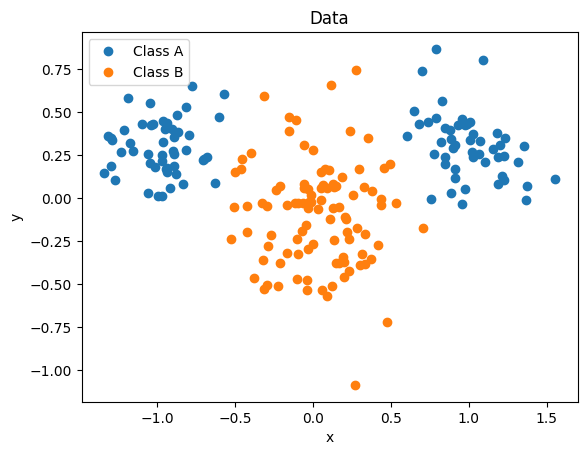

In [ ]:
n_data = 100
mA = [1.0, 0.3]
mB = [0.0, -0.1]
sigmaA = 0.2
sigmaB = 0.3
classA = torch.zeros(2, n_data)
classB = torch.zeros(2, n_data)
classA[0, :n_data//2] = torch.normal(mA[0], sigmaA,
                                     size=(1, n_data//2), generator=generator)
classA[0, n_data//2:] = torch.normal(-mA[0], sigmaA,
                                     size=(1, n_data//2), generator=generator)
classA[1, :] = torch.normal(
    mA[1], sigmaA, size=(1, n_data), generator=generator)
classB[0, :] = torch.normal(
    mB[0], sigmaB, size=(1, n_data), generator=generator)
classB[1, :] = torch.normal(
    mB[1], sigmaB, size=(1, n_data), generator=generator)
train_patterns = torch.cat((classA, classB), dim=1)
train_targets = torch.cat((torch.ones(1, n_data), -torch.ones(1, n_data)), dim=1)


model = TwoLayerPerceptron(train_patterns, train_targets, train_patterns, train_targets, n_hidden=3, n_epochs=100,
                           eta=0.1, alpha=0.9)
model.visualize_data()

100%|██████████| 100/100 [00:00<00:00, 4751.46it/s]


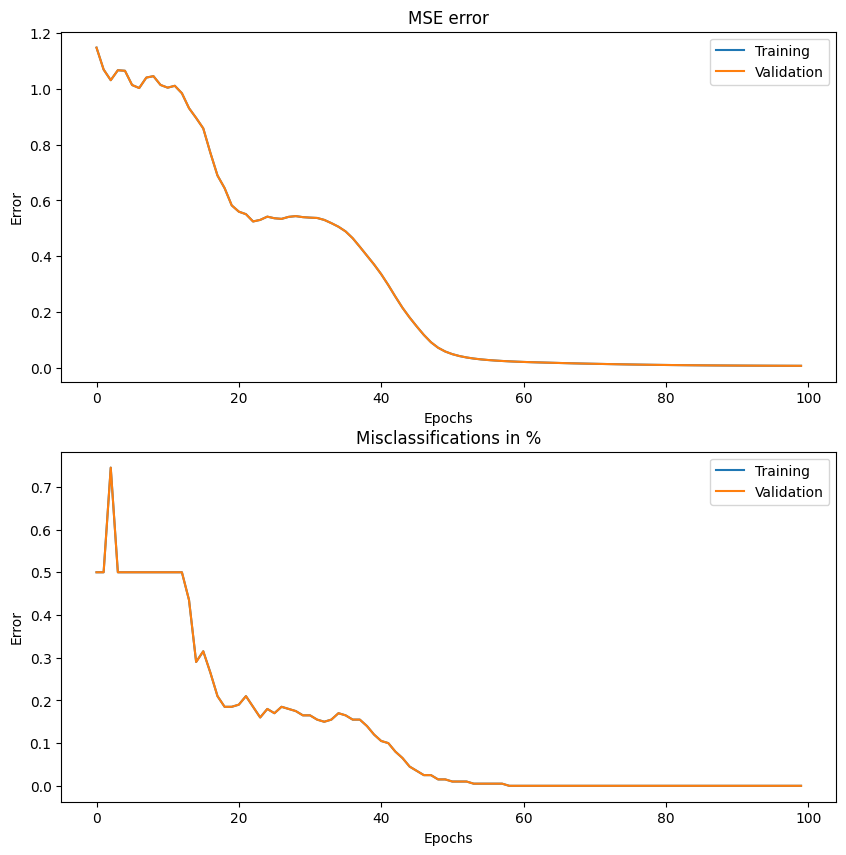

In [ ]:
w, v = model.train()

model.visualize_error()

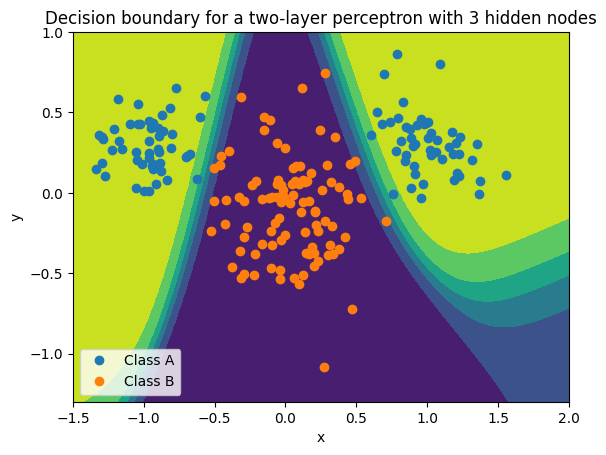

In [ ]:
model.visualize_decision_boundary()

100%|██████████| 150/150 [00:00<00:00, 6855.01it/s]


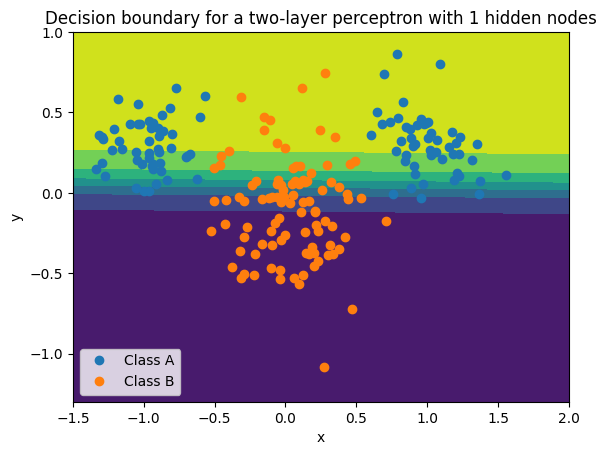

Number of hidden units: 1
MSE error: 0.5086001753807068
Misclassifications: 0.1550000011920929%




100%|██████████| 150/150 [00:00<00:00, 7028.77it/s]


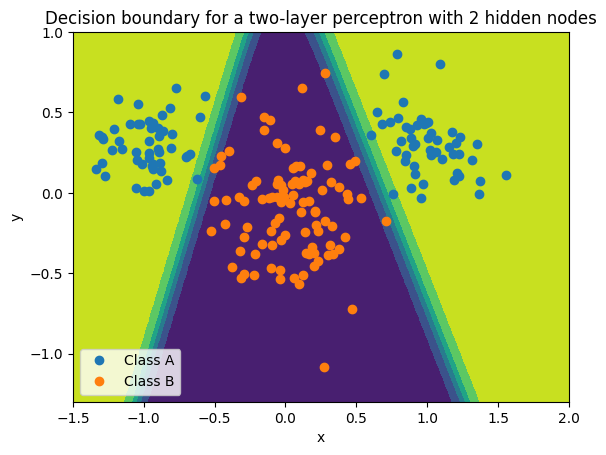

Number of hidden units: 2
MSE error: 0.004775908775627613
Misclassifications: 0.0%




100%|██████████| 150/150 [00:00<00:00, 6735.24it/s]


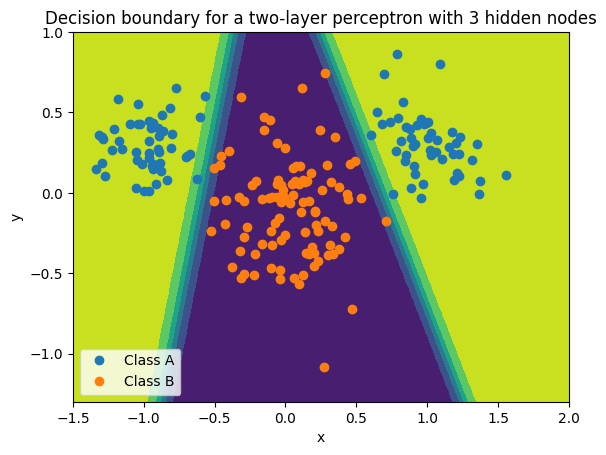

Number of hidden units: 3
MSE error: 0.004009353928267956
Misclassifications: 0.0%




100%|██████████| 150/150 [00:00<00:00, 6650.73it/s]


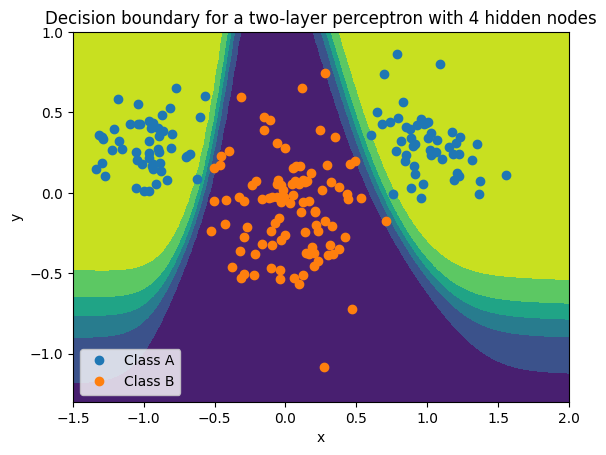

Number of hidden units: 4
MSE error: 0.002368764951825142
Misclassifications: 0.0%




100%|██████████| 150/150 [00:00<00:00, 6637.82it/s]


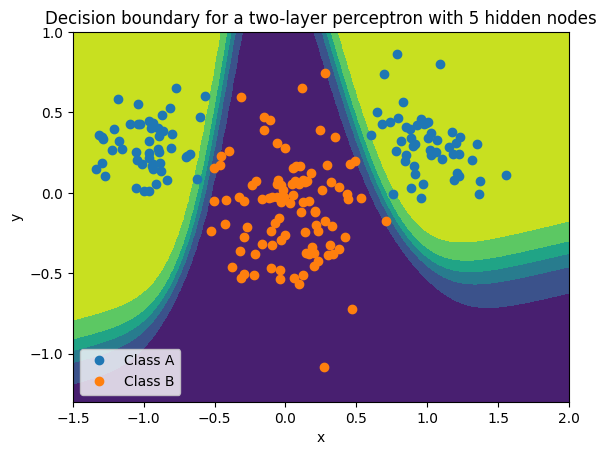

Number of hidden units: 5
MSE error: 0.00264533213339746
Misclassifications: 0.0%




100%|██████████| 150/150 [00:00<00:00, 6349.75it/s]


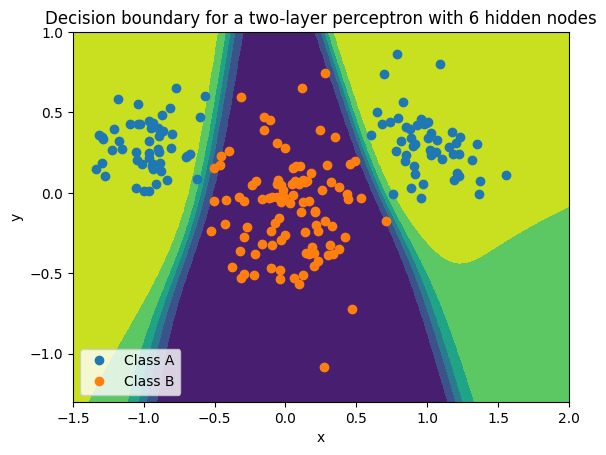

Number of hidden units: 6
MSE error: 0.0028712963685393333
Misclassifications: 0.0%




100%|██████████| 150/150 [00:00<00:00, 6320.59it/s]


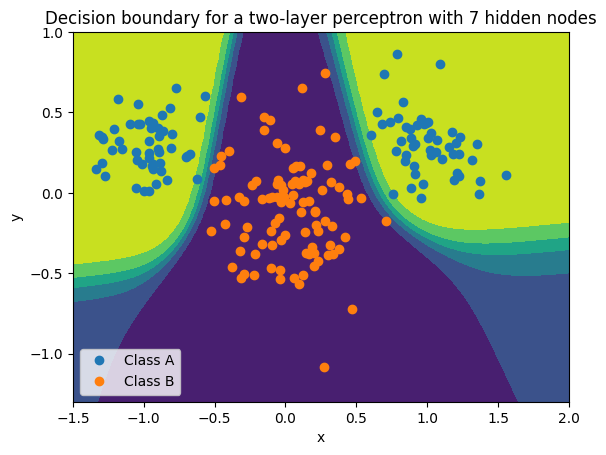

Number of hidden units: 7
MSE error: 0.0018480324652045965
Misclassifications: 0.0%




100%|██████████| 150/150 [00:00<00:00, 5808.32it/s]


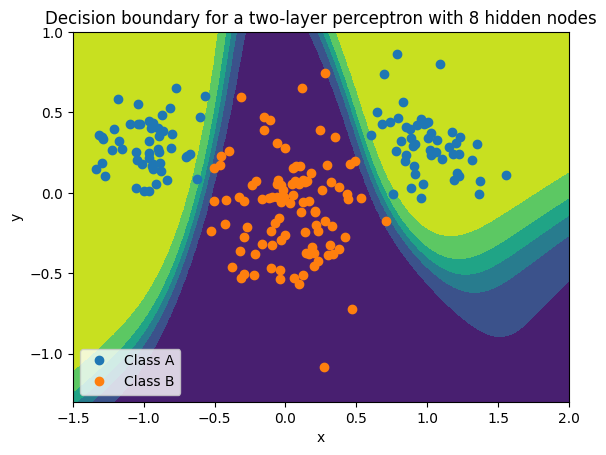

Number of hidden units: 8
MSE error: 0.003502863459289074
Misclassifications: 0.0%




100%|██████████| 150/150 [00:00<00:00, 5896.23it/s]


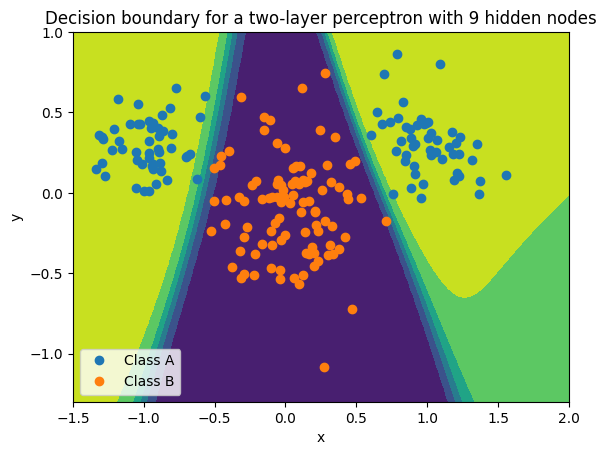

Number of hidden units: 9
MSE error: 0.003119938774034381
Misclassifications: 0.0%




100%|██████████| 150/150 [00:00<00:00, 5922.26it/s]


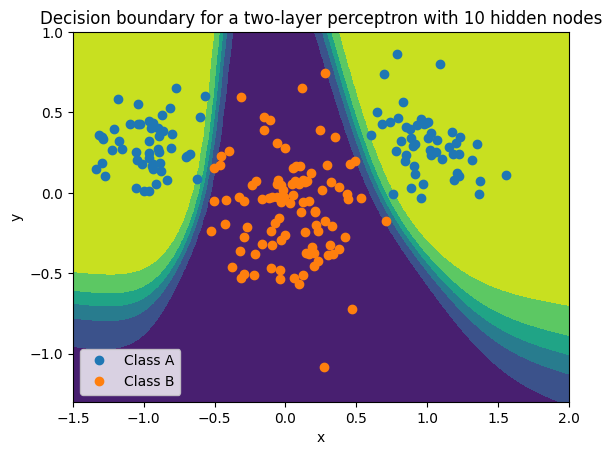

Number of hidden units: 10
MSE error: 0.0017986050806939602
Misclassifications: 0.0%




In [ ]:
for i in range(1,11):
    model = TwoLayerPerceptron(train_patterns, train_targets, train_patterns, train_targets, n_hidden=i, n_epochs=150,
                            eta=0.1, alpha=0.9)
    model.train()
    model.visualize_decision_boundary()
    print(f'Number of hidden units: {i}')
    print(f'MSE error: {model.mse_error_train[-1]}')
    print(f'Misclassifications: {model.misclassifications_val[-1]}%')
    print('\n')

### With validation set

100%|██████████| 100/100 [00:00<00:00, 4429.70it/s]


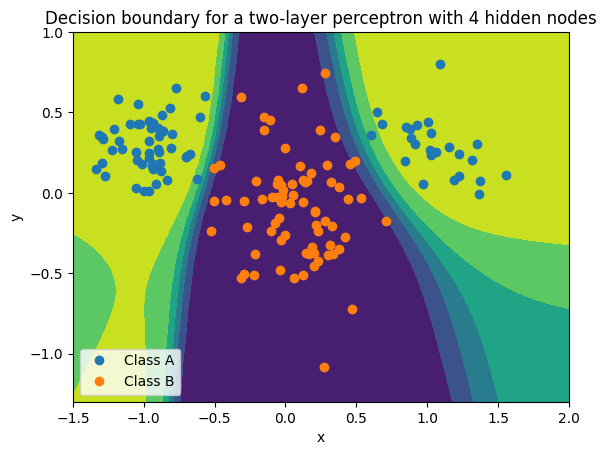

MSE error: 0.004787447862327099
Misclassifications: 0.0


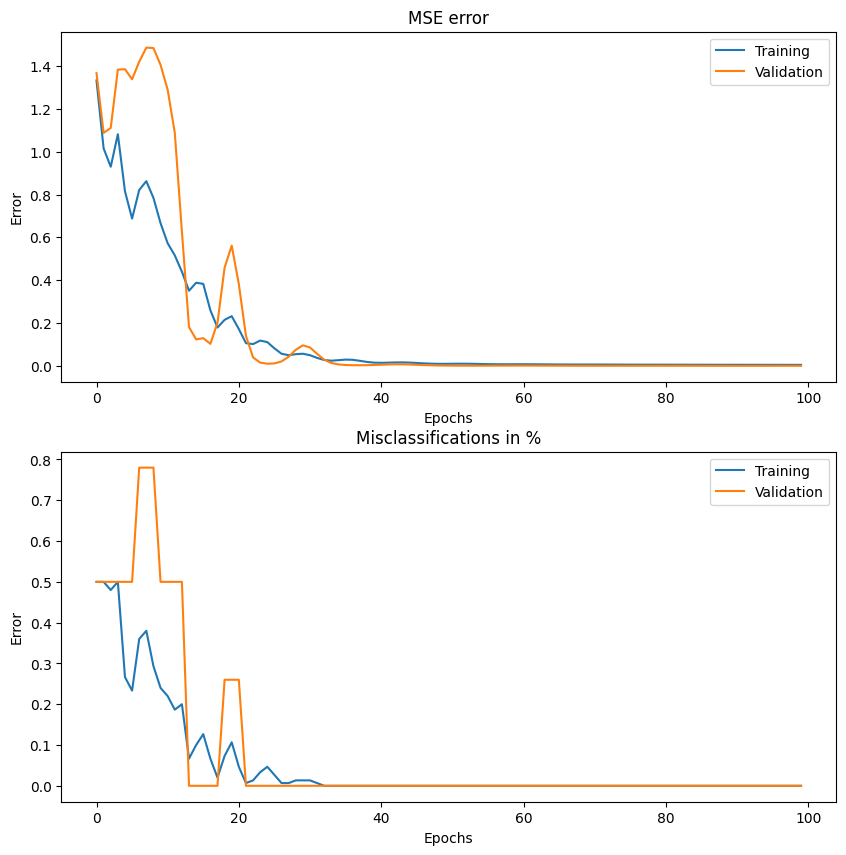

100%|██████████| 100/100 [00:01<00:00, 76.60it/s]


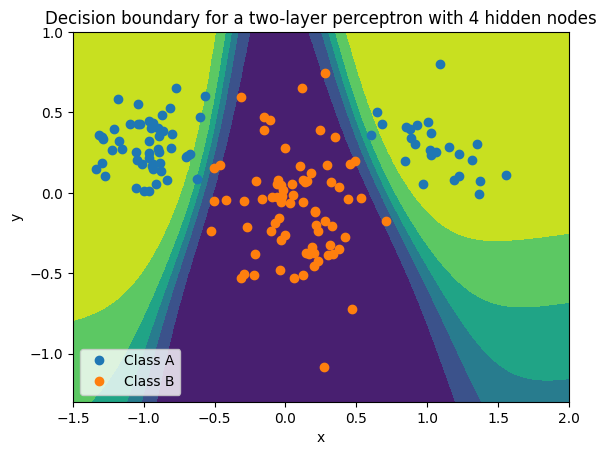

MSE error: 0.010205483064055443
Misclassifications: 0.0


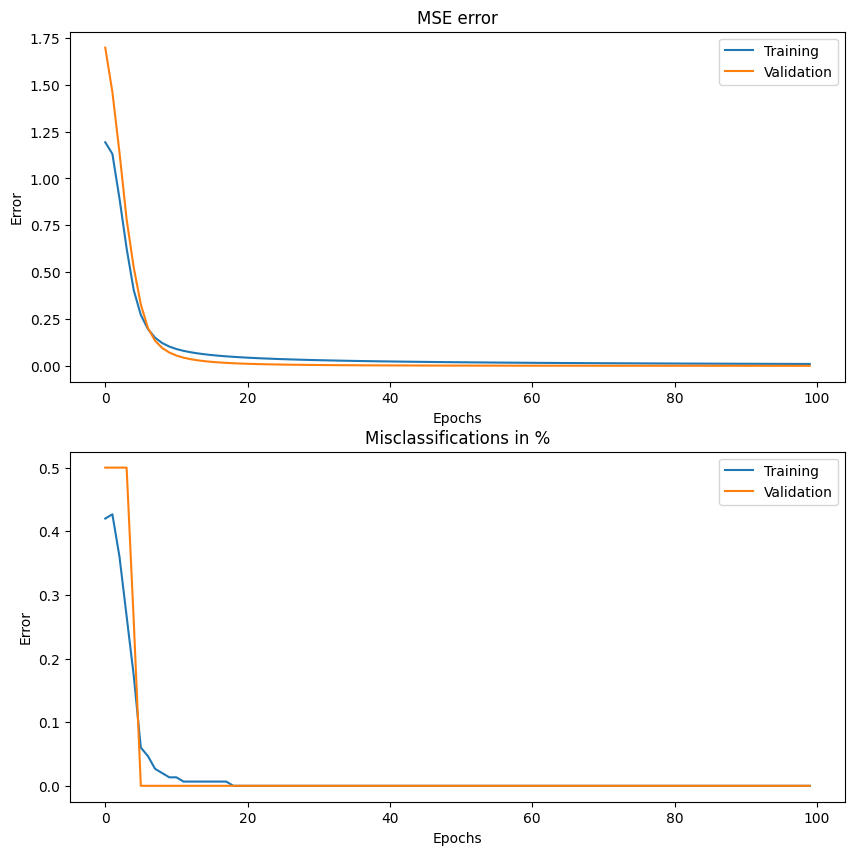

In [ ]:
# Remove 50 samples, randomly chosen 25 from each class

classA_train = classA.clone()
classB_train = classB.clone()
classA_val = torch.zeros(2, 25)
classB_val = torch.zeros(2, 25)

for i in range(25):
    a = random.randint(0, len(classA_train)-1)
    b = random.randint(0, len(classB_train)-1)
    classA_val[:, i] = classA[:, a]
    classB_val[:, i] = classB[:, b]
    classA_train = torch.cat(
        (classA_train[:, :a], classA_train[:, a+1:]), dim=1)
    classB_train = torch.cat(
        (classB_train[:, :b], classB_train[:, b+1:]), dim=1)

classA_targets_train = torch.ones(1, 75)
classB_targets_train = -torch.ones(1, 75)
classA_targets_val = torch.ones(1, 25)
classB_targets_val = -torch.ones(1, 25)

# Concatenate
train_patterns = torch.cat((classA_train, classB_train), dim=1)
train_targets = torch.cat((classA_targets_train, classB_targets_train), dim=1)
val_patterns = torch.cat((classA_val, classB_val), dim=1)
val_targets = torch.cat((classA_targets_val, classB_targets_val), dim=1)

model = TwoLayerPerceptron(train_patterns, train_targets, val_patterns, val_targets, n_hidden=4, n_epochs=100,
                           eta=0.1, alpha=0.9)
model.train()
model.visualize_decision_boundary()
print(f'MSE error: {model.mse_error_train[-1]}')
print(f'Misclassifications: {model.misclassifications_val[-1]}')

model.visualize_error()

model_sequential = TwoLayerPerceptron(train_patterns, train_targets, val_patterns, val_targets, n_hidden=4, n_epochs=100,
                            eta=0.1, alpha=0.9)
model_sequential.train_sequential()
model_sequential.visualize_decision_boundary()
print(f'MSE error: {model_sequential.mse_error_train[-1]}')
print(f'Misclassifications: {model_sequential.misclassifications_val[-1]}')

model_sequential.visualize_error()

100%|██████████| 100/100 [00:00<00:00, 5219.26it/s]


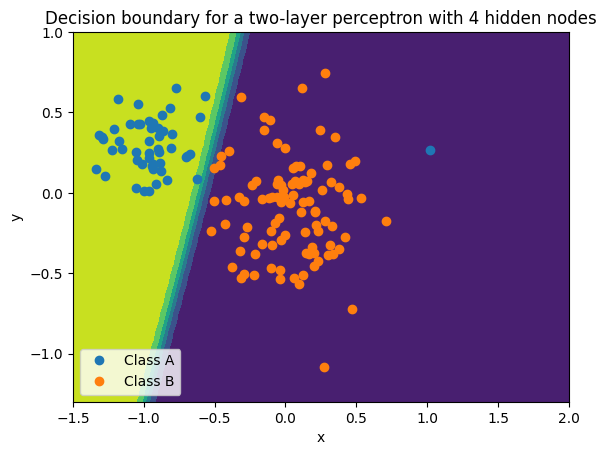

MSE error: 0.027901209890842438
Misclassifications: 1.0


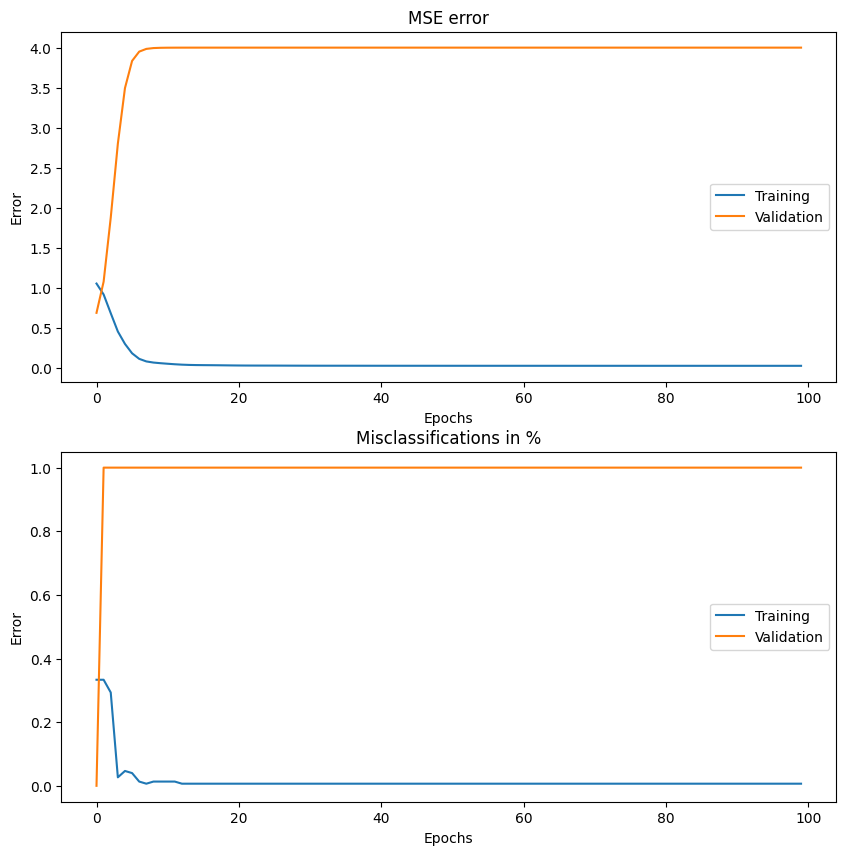

In [ ]:
# Remove 50 samples, randomly chosen 50 from class A

classA_train = classA.clone()
classB_train = classB.clone()
classA_val = torch.zeros(2, 50)

for i in range(50):
    a = random.randint(0, len(classA_train)-1)
    classA_val[:, i] = classA[:, a]
    classA_train = torch.cat(
        (classA_train[:, :a], classA_train[:, a+1:]), dim=1)

classA_targets_train = torch.ones(1, 50)
classB_targets_train = -torch.ones(1, 100)
classA_targets_val = torch.ones(1, 50)
classB_targets_val = -torch.ones(1, 100)

# Concatenate
train_patterns = torch.cat((classA_train, classB_train), dim=1)
train_targets = torch.cat((classA_targets_train, classB_targets_train), dim=1)
#val_patterns = torch.cat((classA_val, classB_val), dim=1)
#val_targets = torch.cat((classA_targets_val, classB_targets_val), dim=1)
val_patterns = classA_val
val_targets = classA_targets_val

model = TwoLayerPerceptron(train_patterns, train_targets, val_patterns, val_targets, n_hidden=4, n_epochs=100,
                           eta=0.1, alpha=0.9)
model.train()
model.visualize_decision_boundary()
print(f'MSE error: {model.mse_error_train[-1]}')
print(f'Misclassifications: {model.misclassifications_val[-1]}')

model.visualize_error()

Number of samples in subset 1: 40
Number of samples in subset 2: 10


100%|██████████| 100/100 [00:00<00:00, 5921.06it/s]


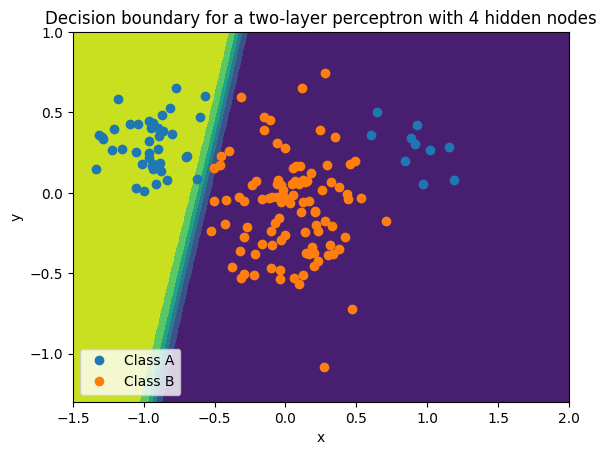

MSE error: 0.2680571973323822
Misclassifications: 0.800000011920929


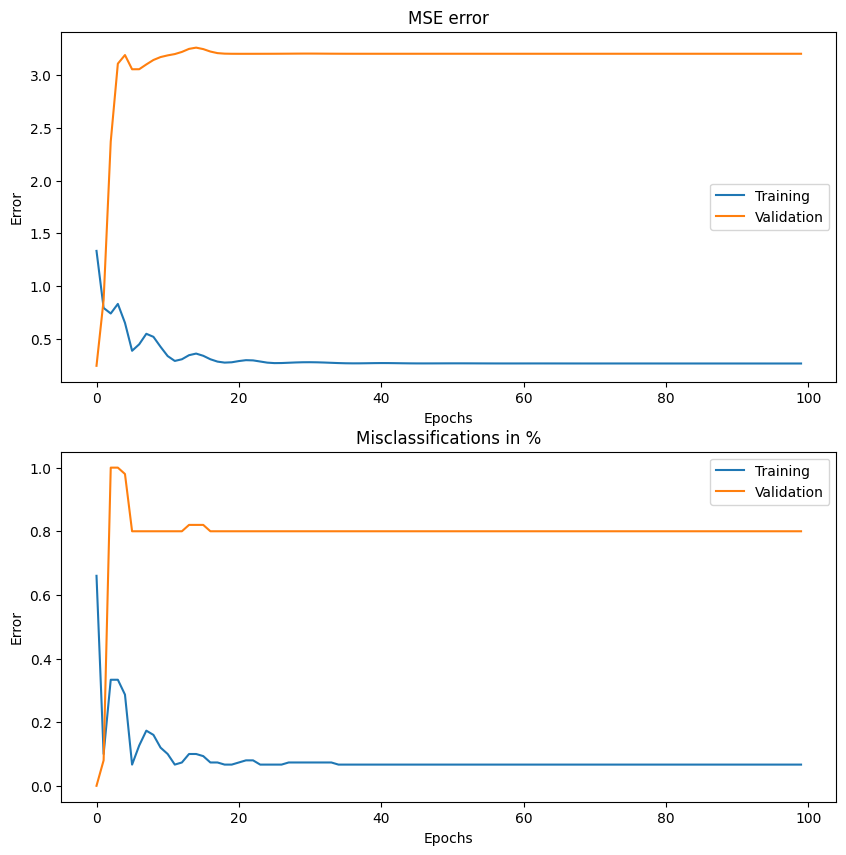

In [ ]:
# Remove 50 samples, 20% from a subset of classA for which classA(1,:)<0 and 80% from a subset of classA for which classA(1,:)>0

classA_train = classA.clone()
classB_train = classB.clone()
classA_val = torch.zeros(2, 50)

# Subset
classA_subset1 = classA[:, classA[0, :] < 0]
classA_subset2 = classA[:, classA[0, :] > 0]

n_data_subset1 = len(classA_subset1[0, :])
n_data_subset2 = len(classA_subset2[0, :])

for i in range(n_data_subset1//5):
    a = random.randint(0, len(classA_subset1)-1)
    classA_val[:, i] = classA_subset1[:, a]
    classA_subset1 = torch.cat(
        (classA_subset1[:, :a], classA_subset1[:, a+1:]), dim=1)

for i in range(4*n_data_subset2//5):
    a = random.randint(0, len(classA_subset2)-1)
    classA_val[:, i+n_data_subset1//5] = classA_subset2[:, a]
    classA_subset2 = torch.cat(
        (classA_subset2[:, :a], classA_subset2[:, a+1:]), dim=1)

n_data_subset1 = len(classA_subset1[0, :])
n_data_subset2 = len(classA_subset2[0, :])

train_patterns = torch.cat((classA_subset1, classA_subset2, classB_train), dim=1)
train_targets = torch.cat((torch.ones(1, n_data_subset1), torch.ones(1, n_data_subset2), -torch.ones(1, n_data)), dim=1)

print(f'Number of samples in subset 1: {n_data_subset1}')
print(f'Number of samples in subset 2: {n_data_subset2}')

# Concatenate
val_patterns = classA_val
val_targets = classA_targets_val

model = TwoLayerPerceptron(train_patterns, train_targets, val_patterns, val_targets, n_hidden=4, n_epochs=100,
                           eta=0.1, alpha=0.9)
model.train()
model.visualize_decision_boundary()
print(f'MSE error: {model.mse_error_train[-1]}')
print(f'Misclassifications: {model.misclassifications_val[-1]}')

model.visualize_error()

### The encoder problem (Non-mandatory task)

### Function approximation

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


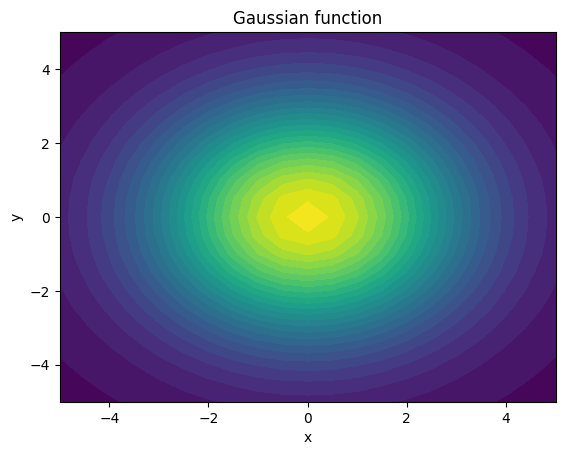

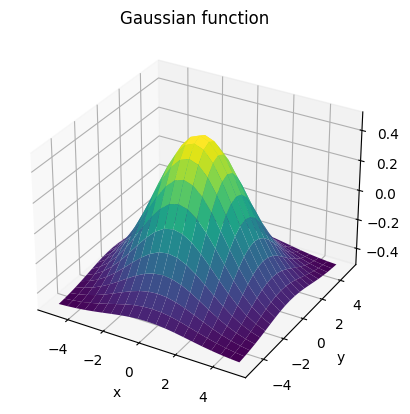

In [ ]:
def gauss_function(x, y):
    return torch.exp(-x*x*0.1-y*y*0.1) - 0.5

n_points = 21
grid_size = n_points*n_points

x = torch.linspace(-5, 5, n_points)
y = torch.linspace(-5, 5, n_points)
X, Y = torch.meshgrid(x, y)
Z = gauss_function(X, Y)

def plotting_gaussian_contour(a, b, c):
    plt.figure()
    plt.contourf(a, b, c, levels=30)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Gaussian function')
    plt.show()

def plotting_gaussian_surface(a, b, c):
    fig = plt.figure()
    axs = fig.add_subplot(111, projection='3d')
    axs.plot_surface(a, b, c, cmap='viridis')
    axs.set_xlabel('x')
    axs.set_ylabel('y')
    axs.set_title('Gaussian function')
    plt.show()

plotting_gaussian_contour(X, Y, Z)
plotting_gaussian_surface(X, Y, Z)

100%|██████████| 100/100 [00:00<00:00, 3376.30it/s]


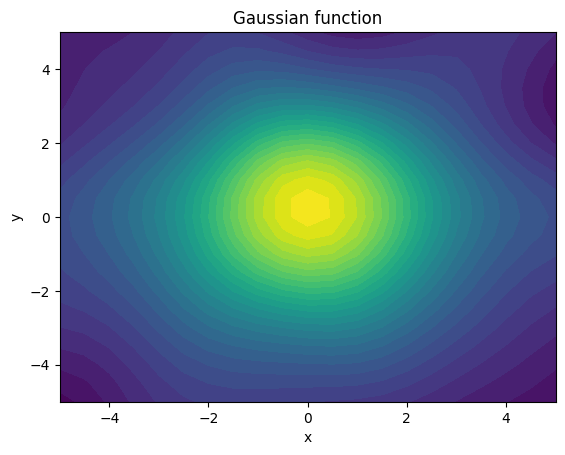

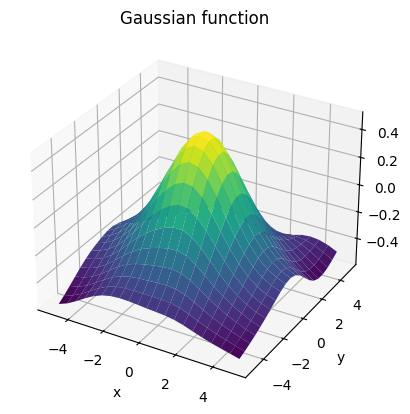

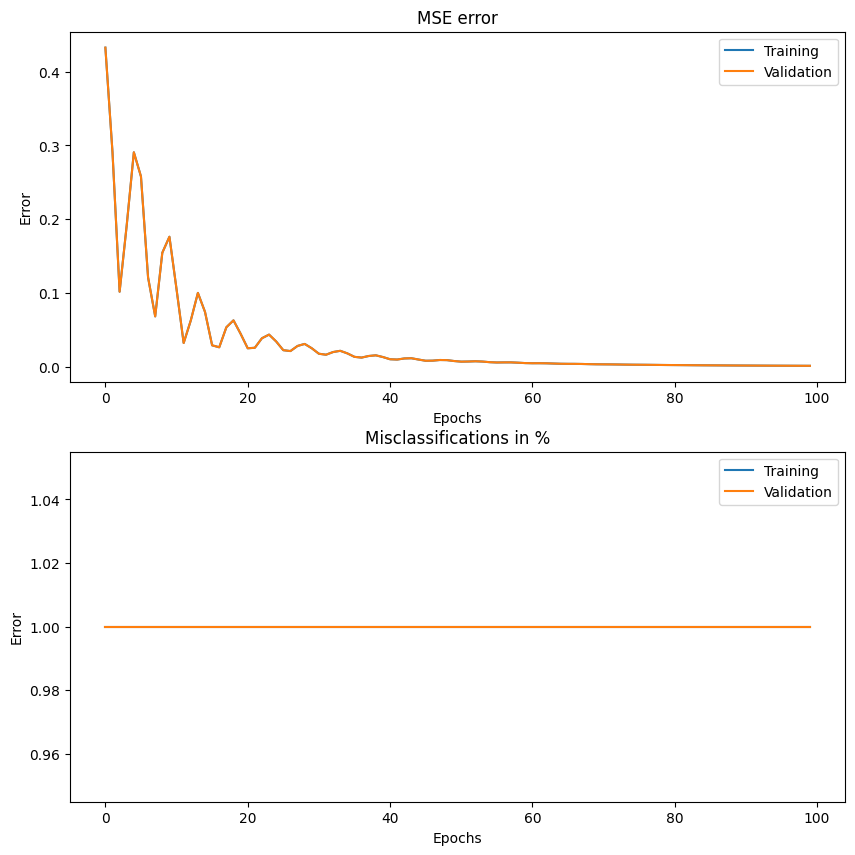

In [ ]:
targets = torch.reshape(Z, (1, grid_size))
patterns = torch.cat((torch.reshape(X, (1, grid_size)), torch.reshape(Y, (1, grid_size))), dim=0)

model = TwoLayerPerceptron(patterns, targets, patterns, targets, n_hidden=10, n_epochs=100,
                            eta=0.01, alpha=0.9)
model.train()

zz = torch.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        zz[i, j] = model.predict(torch.tensor([[X[i, j]], [Y[i, j]]]))

zz = zz.detach().numpy()

plotting_gaussian_contour(X, Y, zz)
plotting_gaussian_surface(X, Y, zz)

model.visualize_error()

Effect of the size of the hidden layer

In [ ]:
def train_varying_hidden_layer_size(X, Y, max_hidden_layer_size, training_patterns, training_targets, val_patterns, val_targets):

    MSE_error_train_hidden = np.zeros((max_hidden_layer_size,))
    MSE_error_val_hidden = np.zeros((max_hidden_layer_size,))

    for i in range(1,max_hidden_layer_size+1):
        model = TwoLayerPerceptron(training_patterns, training_targets, val_patterns, val_targets, n_hidden=i, n_epochs=100,
                                eta=0.01, alpha=0.9)
        model.train()

        zz = torch.zeros_like(X)
        for k in range(X.shape[0]):
            for j in range(X.shape[1]):
                zz[k, j] = model.predict(torch.tensor([[X[k, j]], [Y[k, j]]]))

        zz = zz.detach().numpy()

        plotting_gaussian_contour(X, Y, zz)

        MSE_error_train_hidden[i-1] = model.mse_error_train[-1]
        MSE_error_val_hidden[i-1] = model.mse_error_val[-1]
        print(f'Number of hidden units: {i}')
        print(f'MSE training error: {model.mse_error_train[-1]}')
        print(f'MSE validation error: {model.mse_error_val[-1]}')
        print('\n')

    hidden_layers = np.arange(1,max_hidden_layer_size+1)
    plt.plot(hidden_layers, MSE_error_train_hidden, label='Training Error')
    plt.plot(hidden_layers, MSE_error_val_hidden, label='Validation Error')
    plt.xlabel('Number of units in hidden layer')
    plt.ylabel('MSE')
    plt.title('MSE as a function of number of units in hidden layer')
    plt.legend()
    plt.show()

100%|██████████| 100/100 [00:00<00:00, 6703.27it/s]


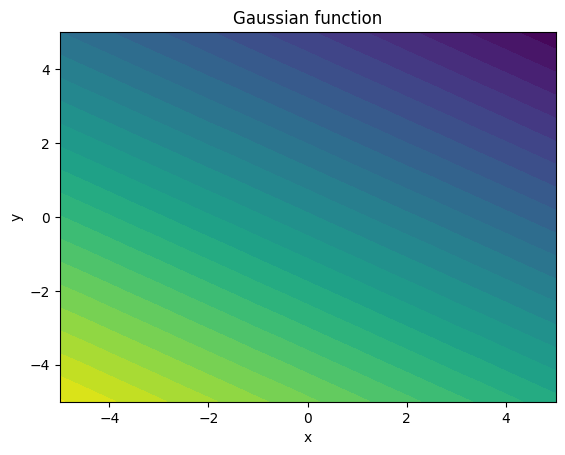

Number of hidden units: 1
MSE training error: 0.06692735850811005
MSE validation error: 0.06692735850811005




100%|██████████| 100/100 [00:00<00:00, 6131.58it/s]


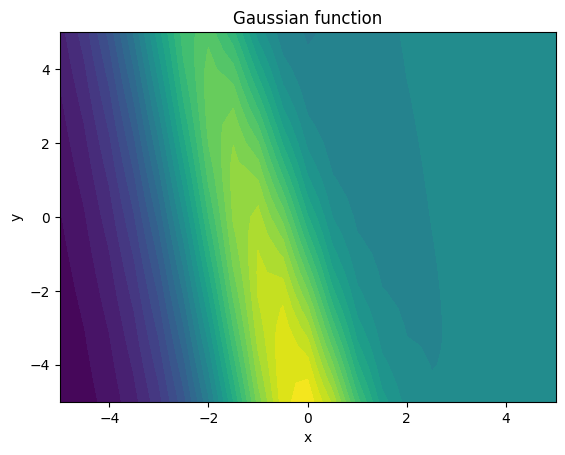

Number of hidden units: 2
MSE training error: 0.05465942621231079
MSE validation error: 0.05465942621231079




100%|██████████| 100/100 [00:00<00:00, 6256.14it/s]


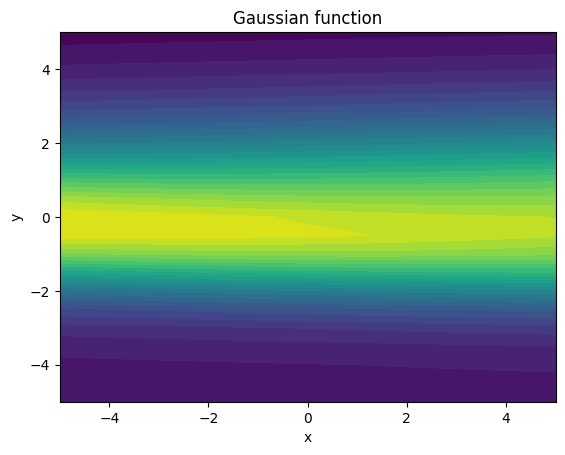

Number of hidden units: 3
MSE training error: 0.04038779065012932
MSE validation error: 0.04038779065012932




100%|██████████| 100/100 [00:00<00:00, 6171.00it/s]


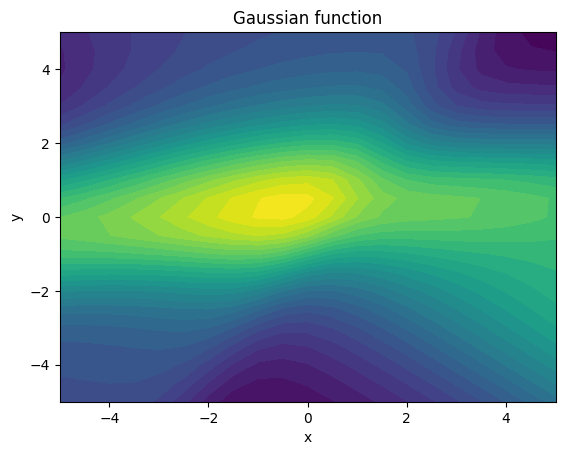

Number of hidden units: 4
MSE training error: 0.0363318994641304
MSE validation error: 0.0363318994641304




100%|██████████| 100/100 [00:00<00:00, 3045.99it/s]


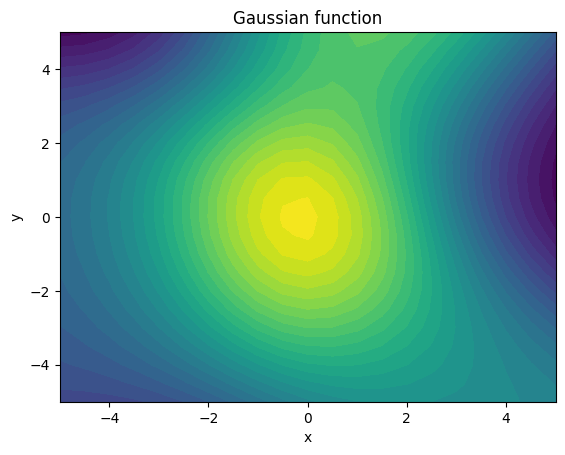

Number of hidden units: 5
MSE training error: 0.02506261132657528
MSE validation error: 0.02506261132657528




100%|██████████| 100/100 [00:00<00:00, 5196.95it/s]


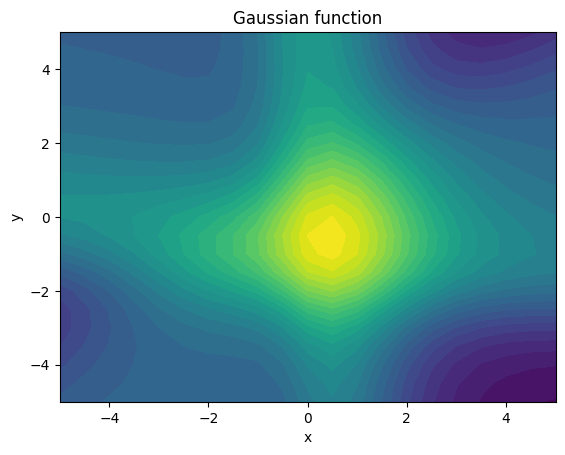

Number of hidden units: 6
MSE training error: 0.015126476064324379
MSE validation error: 0.015126476064324379




100%|██████████| 100/100 [00:00<00:00, 4463.55it/s]


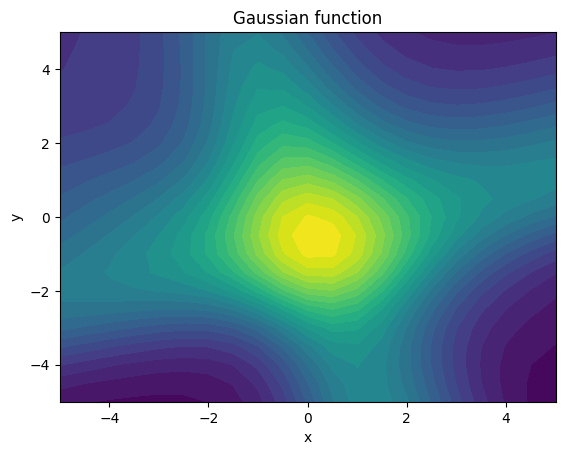

Number of hidden units: 7
MSE training error: 0.013377927243709564
MSE validation error: 0.013377927243709564




100%|██████████| 100/100 [00:00<00:00, 4795.24it/s]


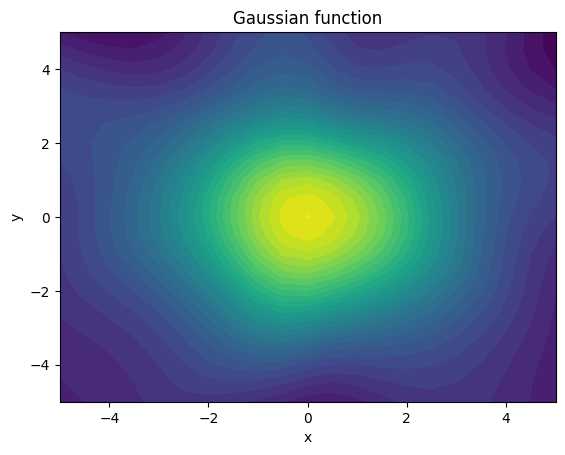

Number of hidden units: 8
MSE training error: 0.0014042191905900836
MSE validation error: 0.0014042191905900836




100%|██████████| 100/100 [00:00<00:00, 4918.62it/s]


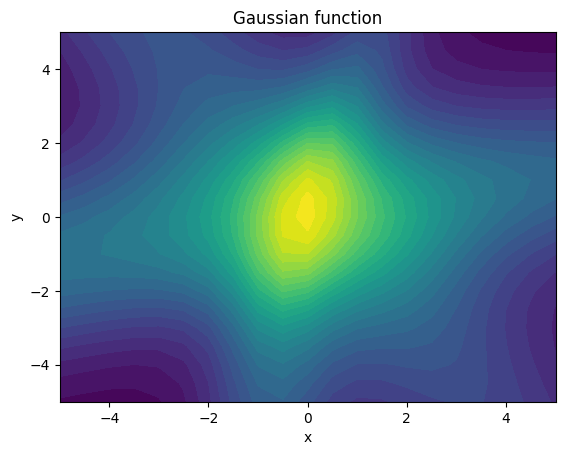

Number of hidden units: 9
MSE training error: 0.007200832478702068
MSE validation error: 0.007200832478702068




100%|██████████| 100/100 [00:00<00:00, 4379.65it/s]


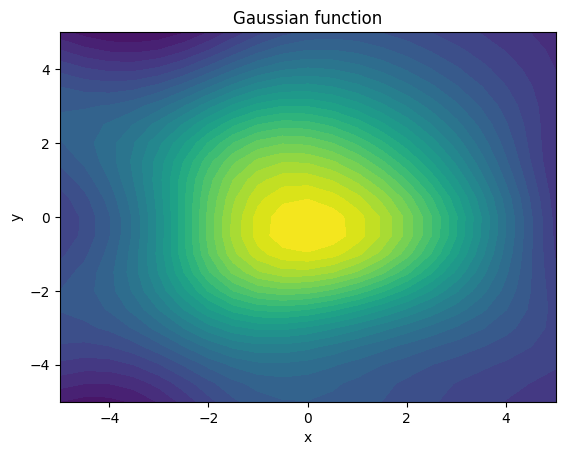

Number of hidden units: 10
MSE training error: 0.0022858292795717716
MSE validation error: 0.0022858292795717716




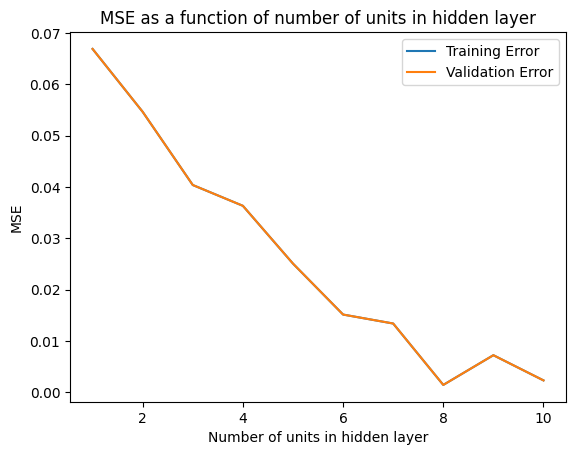

In [ ]:
targets = torch.reshape(Z, (1, grid_size))
patterns = torch.cat((torch.reshape(X, (1, grid_size)), torch.reshape(Y, (1, grid_size))), dim=0)
max_hidden_layers = 10

model = TwoLayerPerceptron(patterns, targets, patterns, targets, n_hidden=12, n_epochs=100,
                            eta=0.01, alpha=0.9)
model.train()

train_varying_hidden_layer_size(X, Y, 10, patterns, targets, patterns, targets)

Evaluate generalisation performance - changing the size of the hidden layer

In [ ]:
def shuffling_data(targets, patterns, percentage, n):
    ## shuffling the input data
    total = torch.cat((targets, patterns), dim=0)
    numpy_total = total.numpy()
    np.random.shuffle(numpy_total.T)
    numpy_patterns = numpy_total[1:, :]
    numpy_targets = numpy_total[0, :]

    ## splitting the data between validation and training data
    n_samp = int(n*n*percentage)

    training_numpy_patterns = numpy_patterns[:, :n_samp+1]
    val_numpy_patterns = numpy_patterns[:, n_samp:]
    training_numpy_targets = numpy_targets[:n_samp+1]
    val_numpy_targets = numpy_targets[n_samp:]

    training_patterns = torch.from_numpy(training_numpy_patterns)
    training_targets = torch.from_numpy(training_numpy_targets)
    val_patterns = torch.from_numpy(val_numpy_patterns)
    val_targets = torch.from_numpy(val_numpy_targets)

    training_targets = training_targets.reshape(1, training_targets.shape[0])
    val_targets = val_targets.reshape(1, val_targets.shape[0])

    return (training_patterns, training_targets, val_patterns, val_targets)

100%|██████████| 100/100 [00:00<00:00, 1136.76it/s]


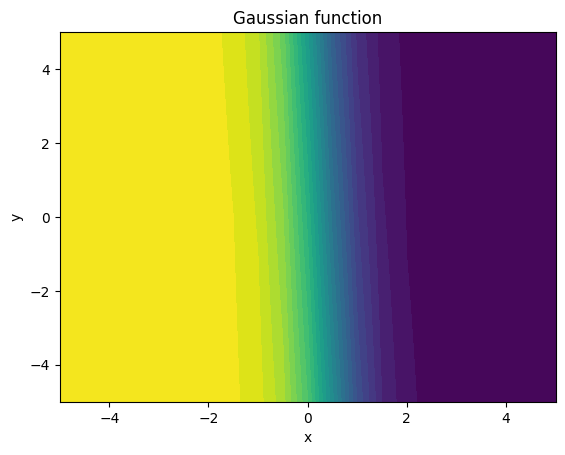

Number of hidden units: 1
MSE training error: 0.06280848383903503
MSE validation error: 0.07244902849197388




100%|██████████| 100/100 [00:00<00:00, 1095.98it/s]


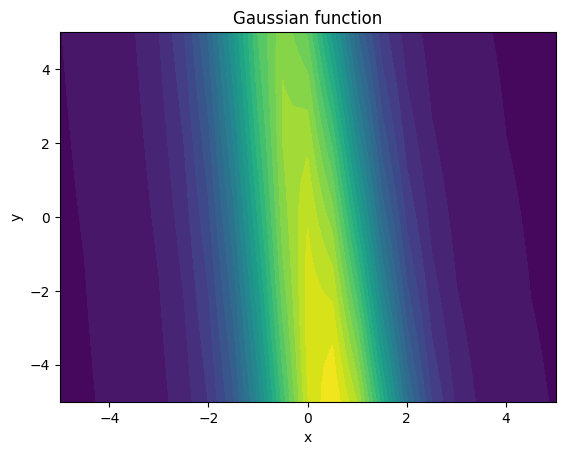

Number of hidden units: 2
MSE training error: 0.043080758303403854
MSE validation error: 0.04779655113816261




100%|██████████| 100/100 [00:00<00:00, 1100.33it/s]


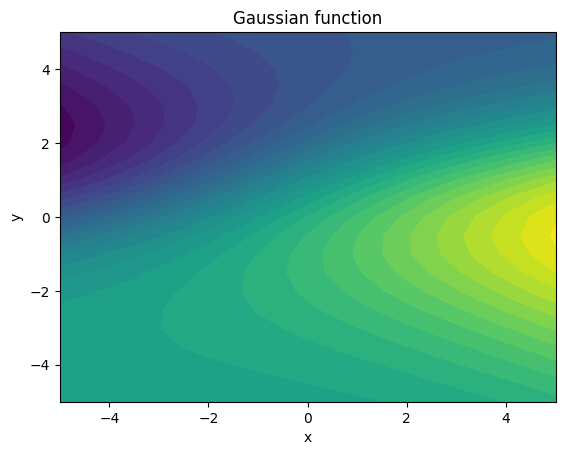

Number of hidden units: 3
MSE training error: 0.060857485979795456
MSE validation error: 0.07043186575174332




100%|██████████| 100/100 [00:00<00:00, 1121.87it/s]


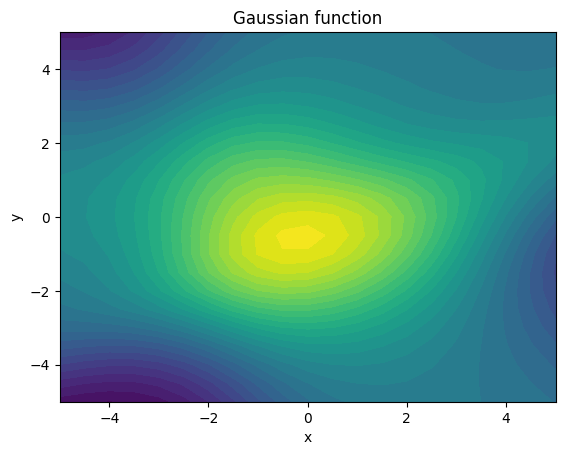

Number of hidden units: 4
MSE training error: 0.014346404932439327
MSE validation error: 0.016238434240221977




100%|██████████| 100/100 [00:00<00:00, 1096.89it/s]


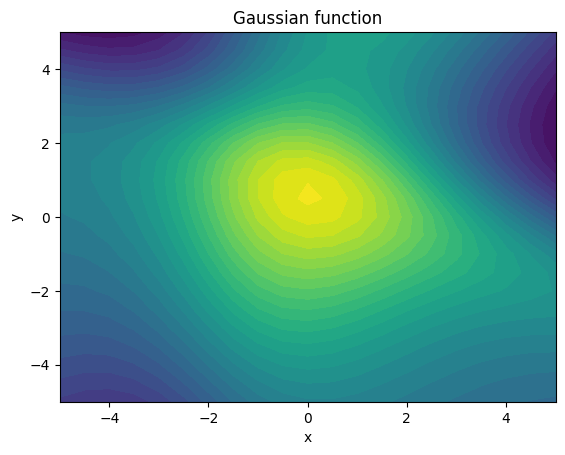

Number of hidden units: 5
MSE training error: 0.02366015687584877
MSE validation error: 0.027354294434189796




100%|██████████| 100/100 [00:00<00:00, 608.46it/s]


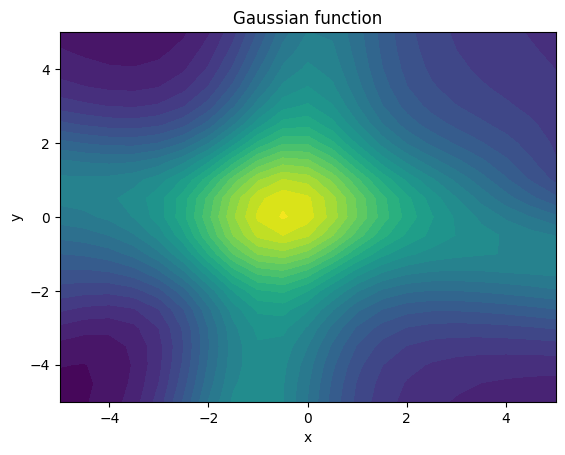

Number of hidden units: 6
MSE training error: 0.012948769144713879
MSE validation error: 0.015115608461201191




100%|██████████| 100/100 [00:00<00:00, 755.27it/s]


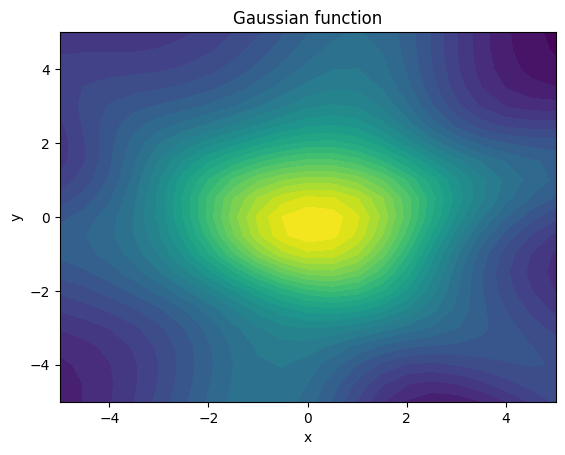

Number of hidden units: 7
MSE training error: 0.00392322801053524
MSE validation error: 0.0049897157587111




100%|██████████| 100/100 [00:00<00:00, 670.58it/s]


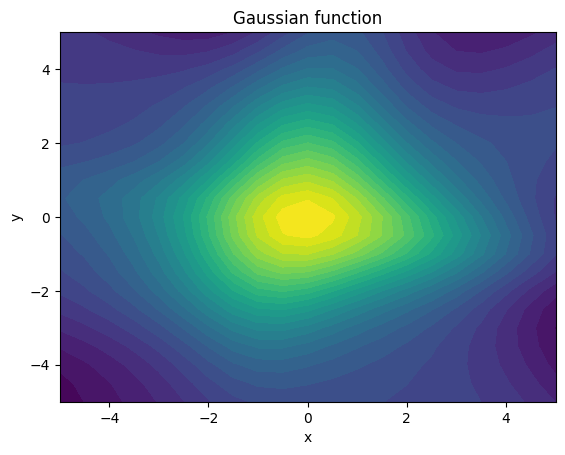

Number of hidden units: 8
MSE training error: 0.0030380920507013798
MSE validation error: 0.0033359152730554342




100%|██████████| 100/100 [00:00<00:00, 603.58it/s]


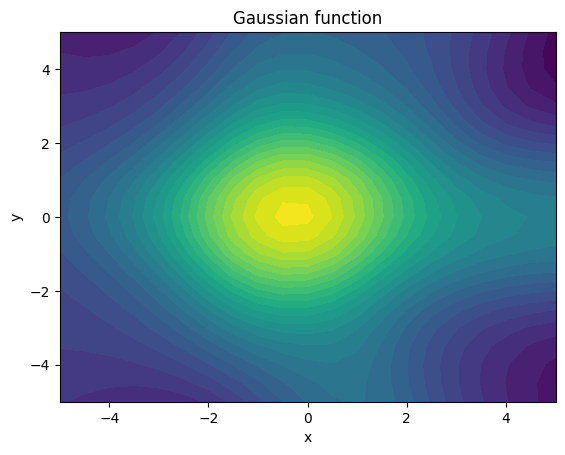

Number of hidden units: 9
MSE training error: 0.005230308510363102
MSE validation error: 0.005311289336532354




100%|██████████| 100/100 [00:00<00:00, 690.50it/s]


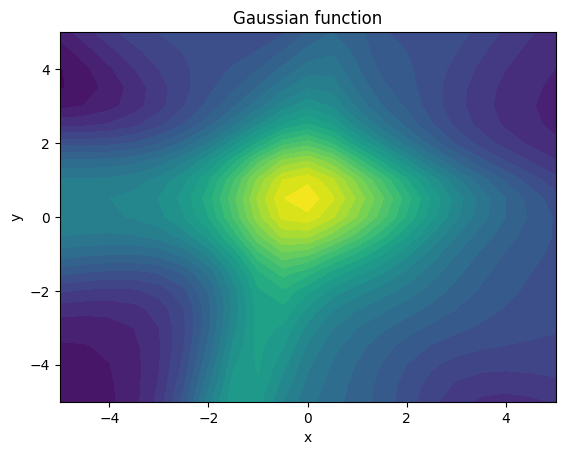

Number of hidden units: 10
MSE training error: 0.011356949806213379
MSE validation error: 0.015091470442712307




100%|██████████| 100/100 [00:00<00:00, 930.90it/s]


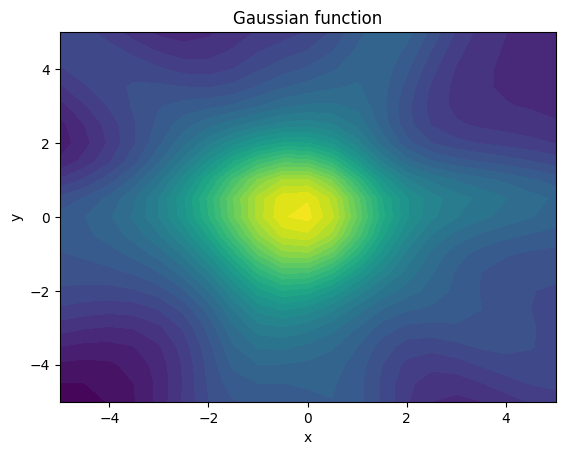

Number of hidden units: 11
MSE training error: 0.007918116636574268
MSE validation error: 0.00890275277197361




100%|██████████| 100/100 [00:00<00:00, 818.45it/s]


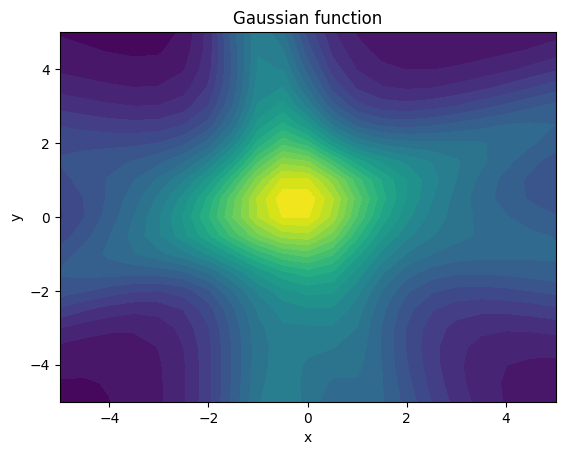

Number of hidden units: 12
MSE training error: 0.014382409863173962
MSE validation error: 0.015023143030703068




100%|██████████| 100/100 [00:00<00:00, 933.13it/s]


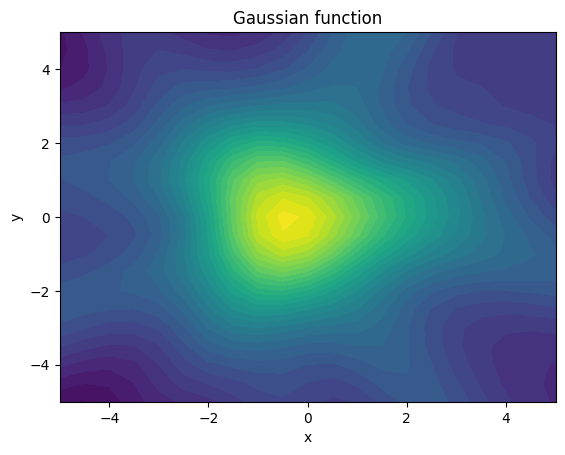

Number of hidden units: 13
MSE training error: 0.005308252293616533
MSE validation error: 0.005961549933999777




100%|██████████| 100/100 [00:00<00:00, 804.27it/s]


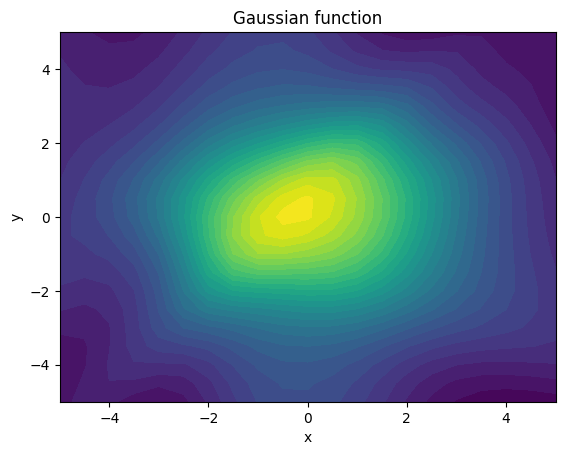

Number of hidden units: 14
MSE training error: 0.001394888968206942
MSE validation error: 0.0015725948614999652




100%|██████████| 100/100 [00:00<00:00, 831.11it/s]


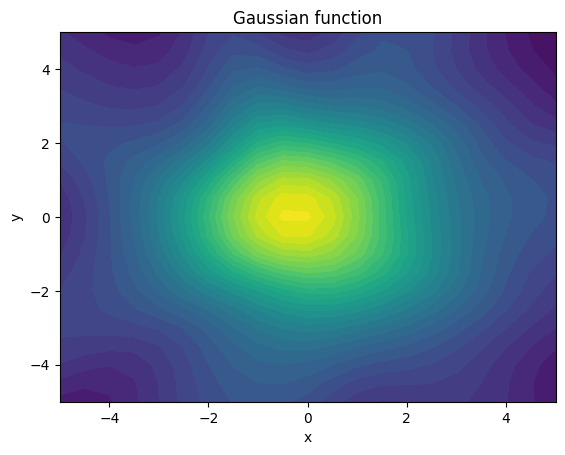

Number of hidden units: 15
MSE training error: 0.0018721092492341995
MSE validation error: 0.0019195118220523




100%|██████████| 100/100 [00:00<00:00, 935.22it/s]


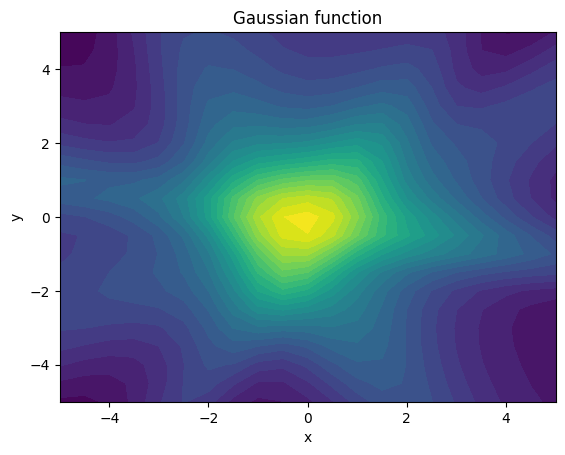

Number of hidden units: 16
MSE training error: 0.006513949483633041
MSE validation error: 0.006677177734673023




100%|██████████| 100/100 [00:00<00:00, 863.31it/s]


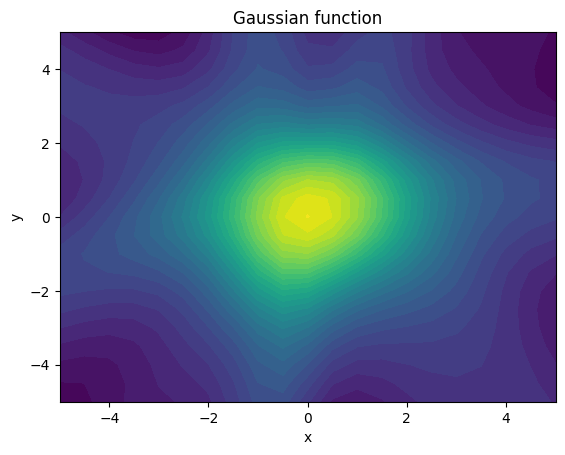

Number of hidden units: 17
MSE training error: 0.004252275917679071
MSE validation error: 0.0042292349971830845




100%|██████████| 100/100 [00:00<00:00, 917.33it/s]


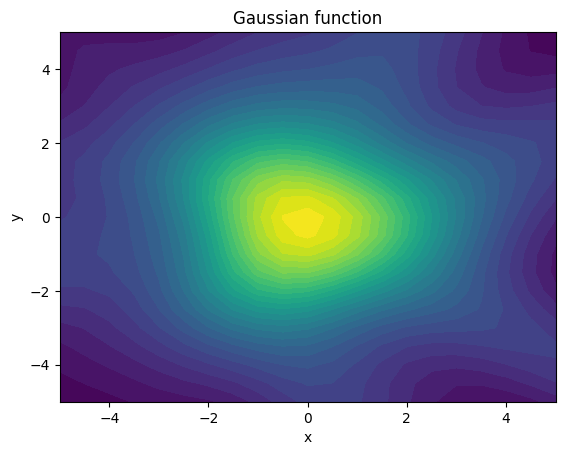

Number of hidden units: 18
MSE training error: 0.0021142815239727497
MSE validation error: 0.002424456411972642




100%|██████████| 100/100 [00:00<00:00, 773.55it/s]


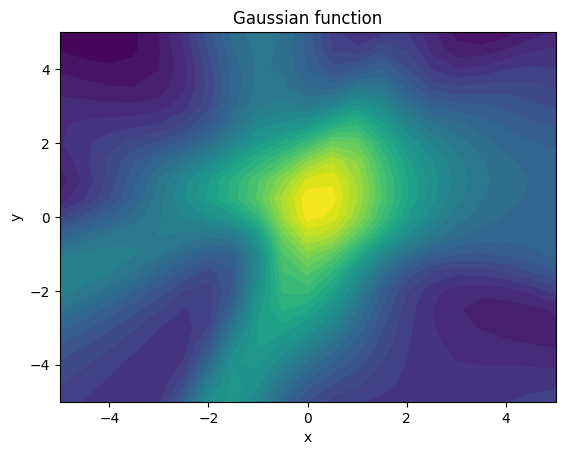

Number of hidden units: 19
MSE training error: 0.018872519955039024
MSE validation error: 0.023140836507081985




100%|██████████| 100/100 [00:00<00:00, 841.89it/s]


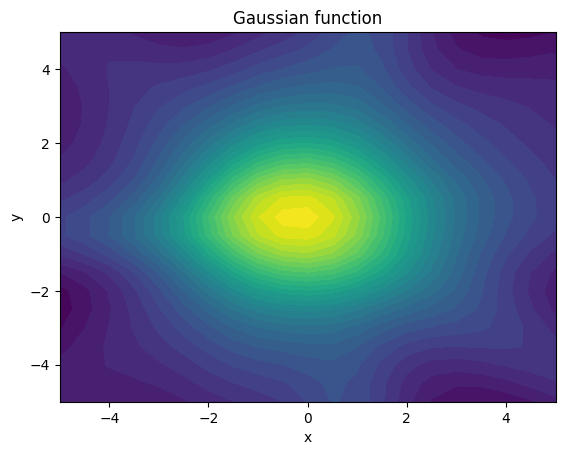

Number of hidden units: 20
MSE training error: 0.002107581589370966
MSE validation error: 0.002453976310789585




100%|██████████| 100/100 [00:00<00:00, 830.78it/s]


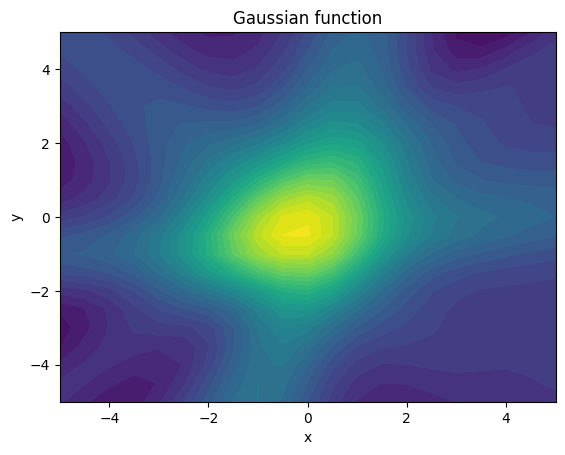

Number of hidden units: 21
MSE training error: 0.008710424415767193
MSE validation error: 0.010985190980136395




100%|██████████| 100/100 [00:00<00:00, 814.04it/s]


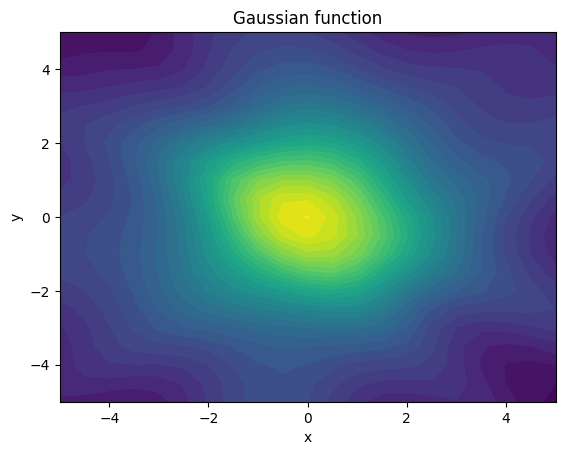

Number of hidden units: 22
MSE training error: 0.002100706100463867
MSE validation error: 0.0026149596087634563




100%|██████████| 100/100 [00:00<00:00, 834.03it/s]


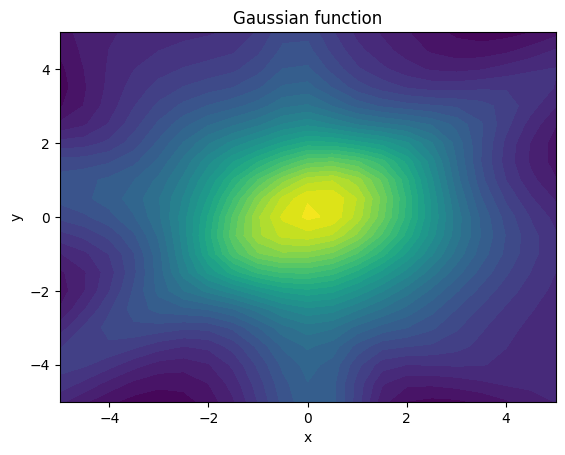

Number of hidden units: 23
MSE training error: 0.002939579077064991
MSE validation error: 0.0032236184924840927




100%|██████████| 100/100 [00:00<00:00, 773.61it/s]


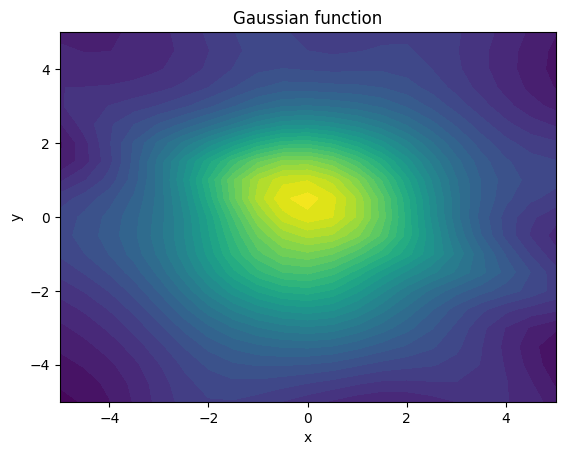

Number of hidden units: 24
MSE training error: 0.0015768654411658645
MSE validation error: 0.0016911678249016404




100%|██████████| 100/100 [00:00<00:00, 818.32it/s]


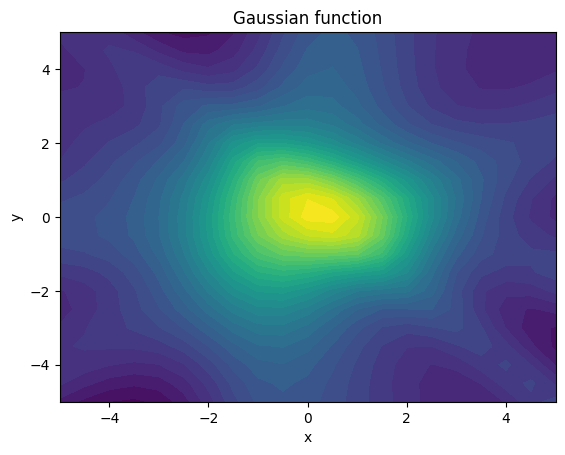

Number of hidden units: 25
MSE training error: 0.004657647106796503
MSE validation error: 0.005324929486960173




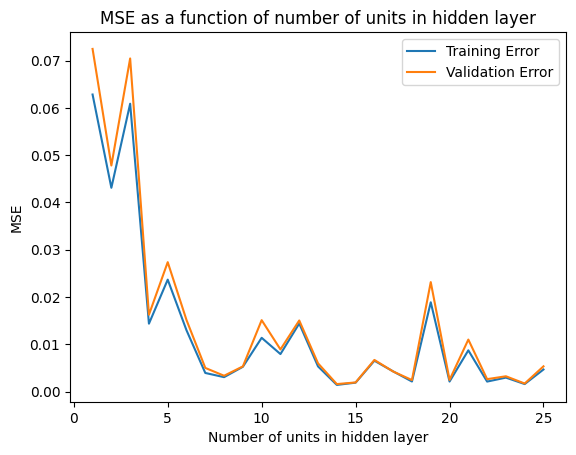

In [ ]:
## initialising the arrays
targets = torch.reshape(Z, (1, grid_size))
patterns = torch.cat((torch.reshape(X, (1, grid_size)), torch.reshape(Y, (1, grid_size))), dim=0)
max_hidden_layers = 25
training_percentage = 0.6

## shuffling the data
training_patterns, training_targets, val_patterns, val_targets = shuffling_data(targets, patterns, training_percentage, n_points)
targets = torch.reshape(Z, (1, grid_size))

## training data
train_varying_hidden_layer_size(X, Y, max_hidden_layers, training_patterns, training_targets, val_patterns, val_targets)

100%|██████████| 100/100 [00:00<00:00, 1132.00it/s]


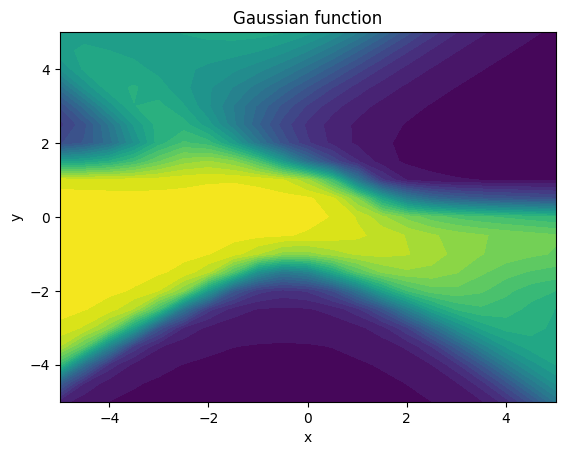

100%|██████████| 100/100 [00:00<00:00, 919.17it/s]


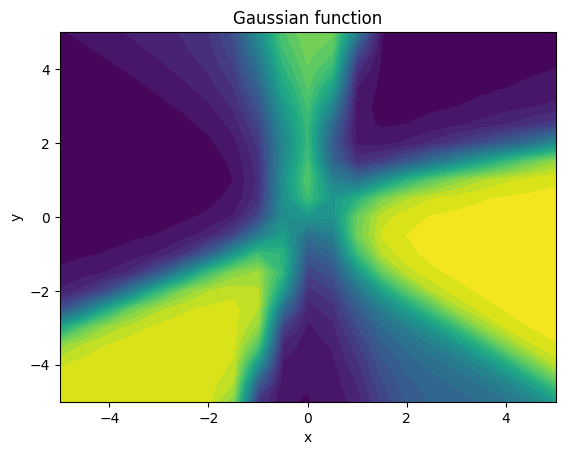

100%|██████████| 100/100 [00:00<00:00, 1084.80it/s]


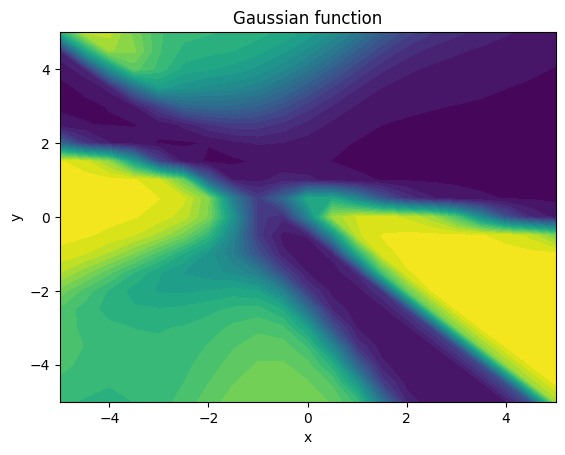

100%|██████████| 100/100 [00:00<00:00, 1043.30it/s]


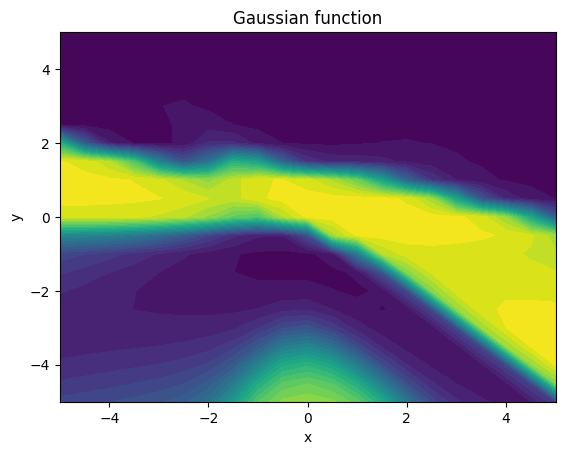

100%|██████████| 100/100 [00:00<00:00, 972.09it/s]


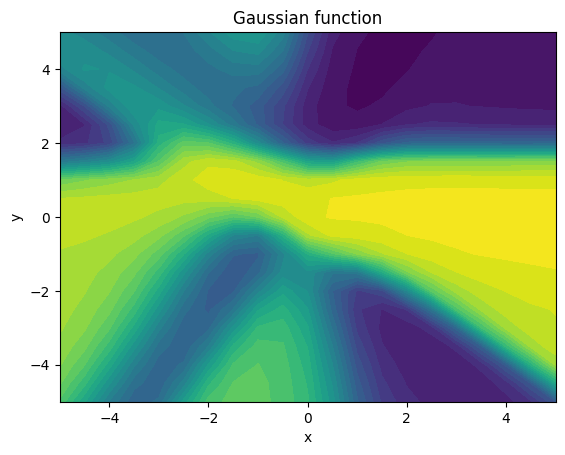

100%|██████████| 100/100 [00:00<00:00, 1016.28it/s]


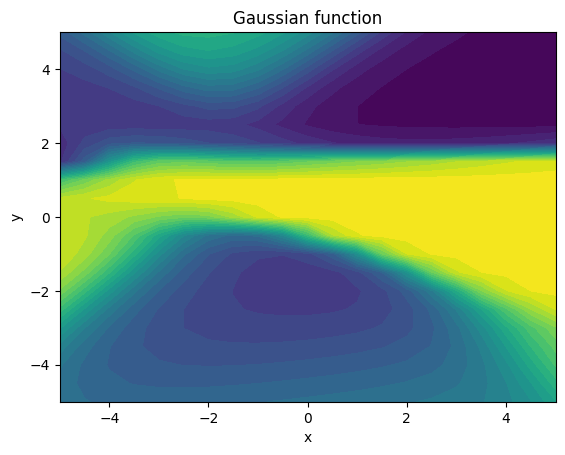

100%|██████████| 100/100 [00:00<00:00, 930.60it/s]


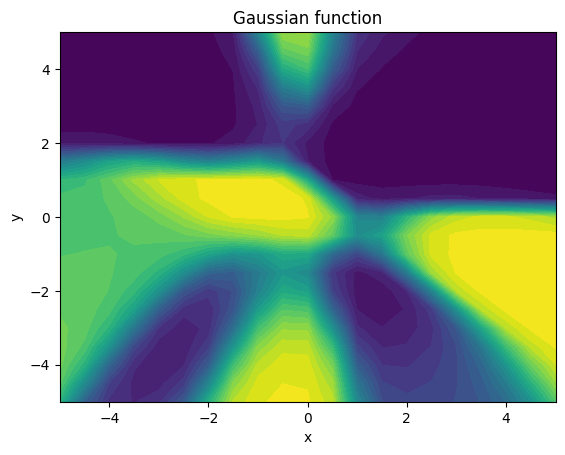

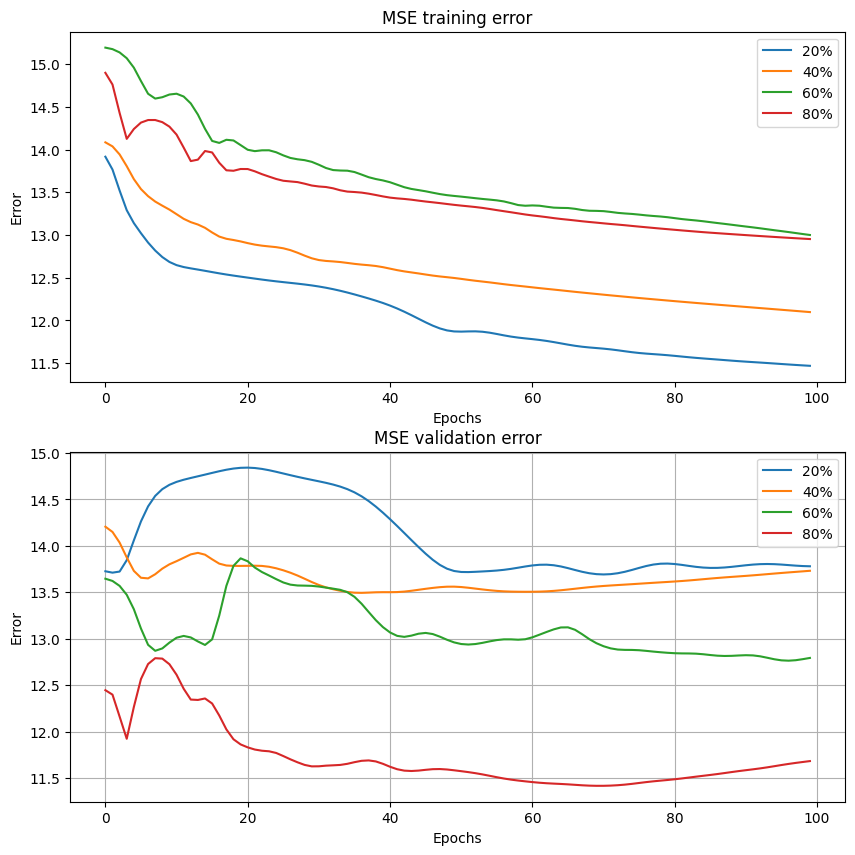

100%|██████████| 100/100 [00:00<00:00, 309.84it/s]


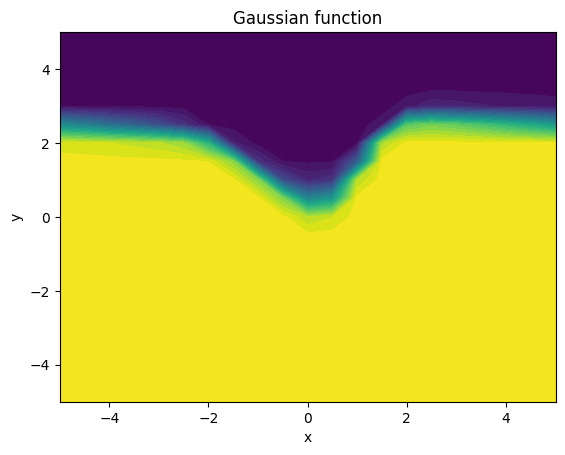

100%|██████████| 100/100 [00:00<00:00, 322.34it/s]


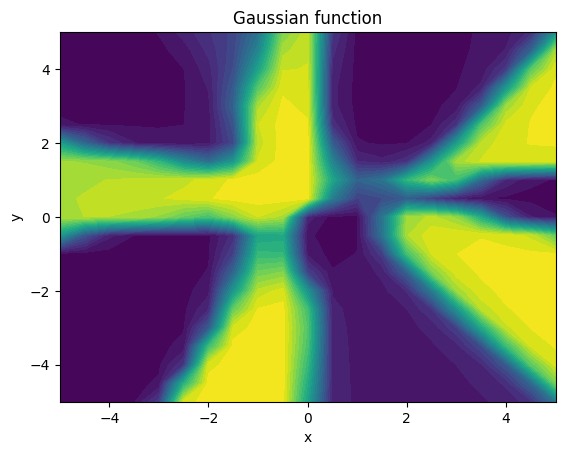

100%|██████████| 100/100 [00:00<00:00, 312.47it/s]


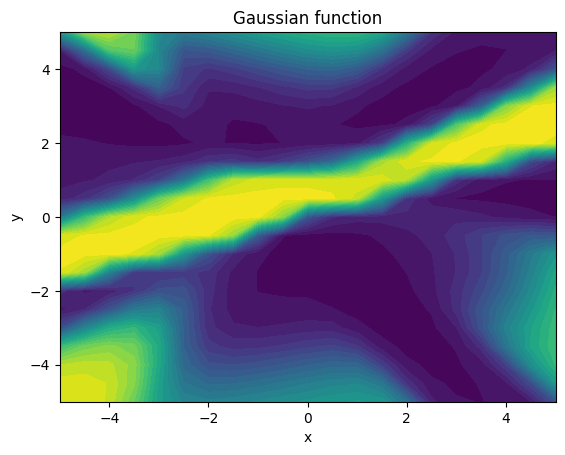

100%|██████████| 100/100 [00:00<00:00, 558.43it/s]


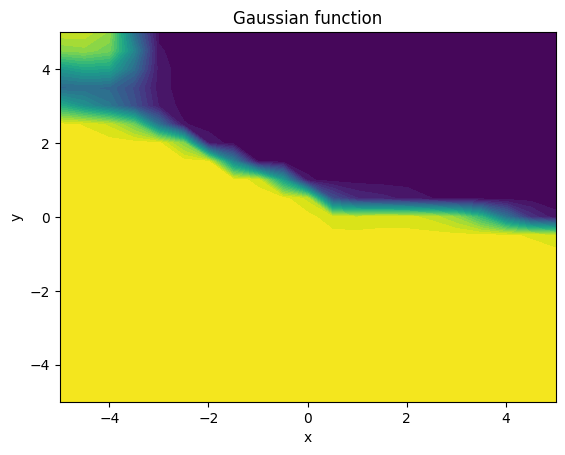

100%|██████████| 100/100 [00:00<00:00, 442.83it/s]


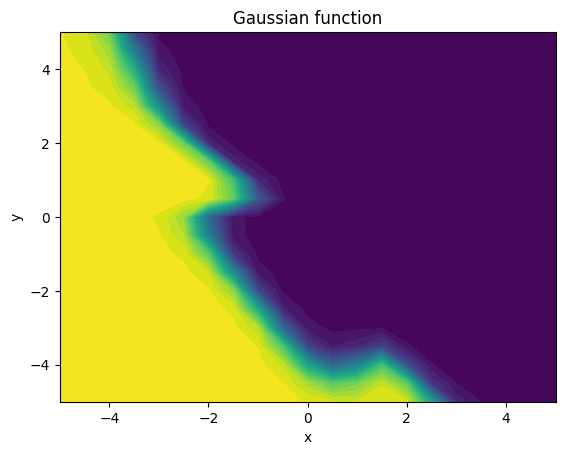

100%|██████████| 100/100 [00:00<00:00, 519.99it/s]


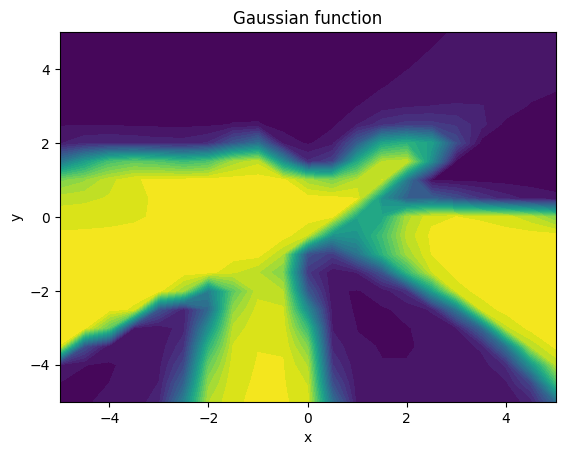

100%|██████████| 100/100 [00:00<00:00, 509.47it/s]


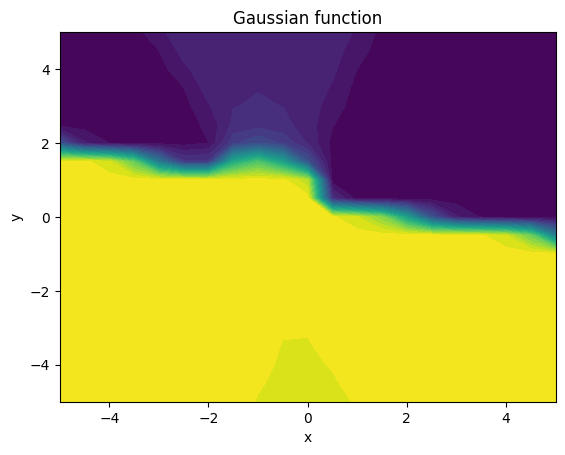

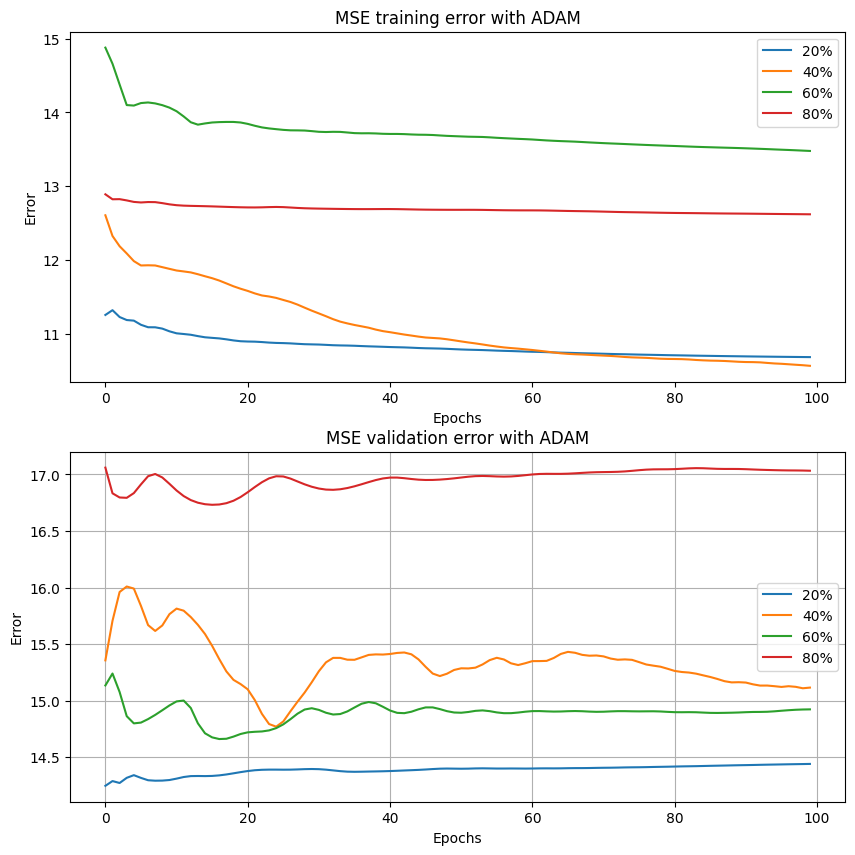

In [ ]:
## initialising the arrays
targets = torch.reshape(Z, (1, grid_size))
patterns = torch.cat((torch.reshape(X, (1, grid_size)), torch.reshape(Y, (1, grid_size))), dim=0)
hidden_layer_size = 12



def varying_training_data(X, Y, hidden_layer_size, training_patterns, training_targets, patterns, targets):
    val_curve, train_curve = np.zeros((7, 100)), np.zeros((7, 100))
    for p in range(2, 9):
        training_patterns, training_targets, val_patterns, val_targets = shuffling_data(targets, patterns, p/10, n_points)

        model = TwoLayerPerceptron(training_patterns, training_targets, val_patterns, val_targets, n_hidden=hidden_layer_size, n_epochs=100,
                                eta=0.01, alpha=0.9)
        model.train()

        zz = torch.zeros_like(X)
        for k in range(X.shape[0]):
            for j in range(X.shape[1]):
                zz[k, j] = model.predict(torch.tensor([[X[k, j]], [Y[k, j]]]))

        zz = zz.detach().numpy()
        plotting_gaussian_contour(X, Y, zz)

        val_curve[p-2, :] = model.mse_error_val
        train_curve[p-2, :] = model.mse_error_train

    fig, axs = plt.subplots(2, figsize=(10, 10))

    for p in range(4):
        axs[0].plot(train_curve[p*2, :])
        axs[1].plot(val_curve[p*2, :])

    axs[0].set_title('MSE training error')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Error')
    axs[1].set_title('MSE validation error')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Error')
    axs[1].legend([f'{(2*p+2)*10}%' for p in range(4)])
    axs[0].legend([f'{(2*p+2)*10}%' for p in range(4)])
    plt.grid()
    plt.show()

def varying_training_data_adam(X, Y, hidden_layer_size, training_patterns, training_targets, patterns, targets):
    val_curve, train_curve = np.zeros((7, 100)), np.zeros((7, 100))
    for p in range(2, 9):
        training_patterns, training_targets, val_patterns, val_targets = shuffling_data(targets, patterns, p/10, n_points)

        model = TwoLayerPerceptron(training_patterns, training_targets, val_patterns, val_targets, n_hidden=hidden_layer_size, n_epochs=100,
                                eta=0.1, alpha=0.9)
        model.train_adam()

        zz = torch.zeros_like(X)
        for k in range(X.shape[0]):
            for j in range(X.shape[1]):
                zz[k, j] = model.predict(torch.tensor([[X[k, j]], [Y[k, j]]]))

        zz = zz.detach().numpy()
        plotting_gaussian_contour(X, Y, zz)

        val_curve[p-2, :] = model.mse_error_val
        train_curve[p-2, :] = model.mse_error_train

    fig, axs = plt.subplots(2, figsize=(10, 10))

    for p in range(4):
        axs[0].plot(train_curve[p*2, :])
        axs[1].plot(val_curve[p*2, :])

    axs[0].set_title('MSE training error with ADAM')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Error')
    axs[1].set_title('MSE validation error with ADAM')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Error')
    axs[1].legend([f'{(2*p+2)*10}%' for p in range(4)])
    axs[0].legend([f'{(2*p+2)*10}%' for p in range(4)])
    plt.grid()
    plt.show()

## training the model
varying_training_data(X, Y, hidden_layer_size, training_patterns, training_targets, patterns, targets)
varying_training_data_adam(X, Y, hidden_layer_size, training_patterns, training_targets, patterns, targets)

100%|██████████| 100/100 [00:00<00:00, 944.45it/s]


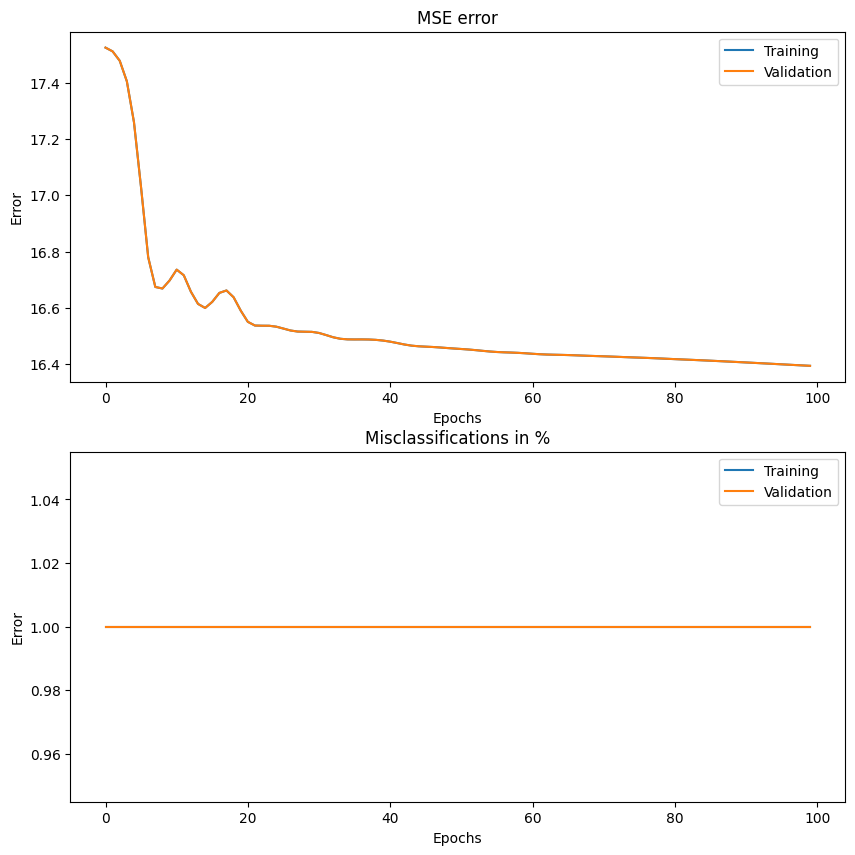

100%|██████████| 100/100 [00:00<00:00, 789.60it/s]


In [ ]:
## initialising the arrays
def adding_gaussian_noise(noise_percentage, noise_variance):
    noise_percentage = 20
    num_targets_to_add_noise = int((noise_percentage / 100) * grid_size)
    indices_to_add_noise = torch.randperm(grid_size)[:num_targets_to_add_noise]
    noise_variance = 2
    noise = torch.randn(1, num_targets_to_add_noise) * noise_variance
    targets[:, indices_to_add_noise] += noise
    return targets

targets = torch.reshape(Z, (1, grid_size))
patterns = torch.cat((torch.reshape(X, (1, grid_size)), torch.reshape(Y, (1, grid_size))), dim=0)
hidden_layer_size = 12

## a few outliers
targets = adding_gaussian_noise(20, 2)

model = TwoLayerPerceptron(patterns, targets, patterns, targets, n_hidden=12, n_epochs=100,
                            eta=0.01, alpha=0.9)
model.train()

zz = torch.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        zz[i, j] = model.predict(torch.tensor([[X[i, j]], [Y[i, j]]]))
zz = zz.detach().numpy()

plotting_gaussian_contour(X, Y, zz)

model.visualize_error()

## low noise for all data
targets = adding_gaussian_noise(80, 0.1)

model = TwoLayerPerceptron(patterns, targets, patterns, targets, n_hidden=12, n_epochs=100,
                            eta=0.01, alpha=0.9)
model.train()

zz = torch.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        zz[i, j] = model.predict(torch.tensor([[X[i, j]], [Y[i, j]]]))
zz = zz.detach().numpy()

plotting_gaussian_contour(X, Y, zz)

model.visualize_error()



## MLP neural network for chaotic time-series prediction
Let's import the library that we will use to build or neural network.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras import activations
from keras import regularizers
from keras import callbacks
from keras.optimizers import SGD

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import random
import warnings

generator = torch.manual_seed(2)
# remove warnings
warnings.filterwarnings('ignore')


### Generating data


In [ ]:
# Function generating the Mackey-Glass time series
def mackey_glass_time_series (beta, gamma, n, tau, x0, N_samples) :
    time_series = [x0*(1 - gamma)**t for t in range(tau+1)]
    for t in range(tau, N_samples-1):
        time_series.append(time_series[t] + (beta*time_series[t-tau])/(1+time_series[t-tau]**n) - gamma*time_series[t])
    return np.array(time_series)


In [ ]:
### Parameters
beta = 0.2
gamma = 0.1
n = 10
tau = 25
N_samples = 1505
x0 = 1.5


In [ ]:
# Function that builds the first dataset
def build_dataset(noised=False, noise_std=0.1):
    global beta, gamma, n, tau, x0, N_samples

    # Generating time series and building dataset
    if not noised :
        Y = mackey_glass_time_series(beta, gamma, n, tau, x0, N_samples)
    else :
        Y = mackey_glass_time_series(beta, gamma, n, tau, x0, N_samples)
        Y += np.random.normal(loc = 0, scale= noise_std, size=Y.shape)

    # Building the dataset
    X = np.zeros((N_samples-5, 5))
    for i in range(N_samples-5):
        X[i, :] = Y[i:i+5]

    # Synchronising labels with inputs
    Y = Y[5:]

    # Keeping the last 1200 samples
    X = X[300:, :]
    Y = Y[300:]

    return X, Y

# Function that split data into training validation and test sets
def split_data(X, Y) :
    X_train = X[:800, :]
    Y_train = Y[:800]

    X_val = X[800:1000, :]
    Y_val = Y[800:1000]

    X_test = X[1000:, :]
    Y_test = Y[1000:]
    return X_train, Y_train, X_val, Y_val, X_test, Y_test


In [ ]:
X, Y = build_dataset()

X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data(X, Y)

### Shape checking
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape, "\n")
print("X_val shape: ", X_val.shape)
print("Y_val shape: ", Y_val.shape, "\n")
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)


X_train shape:  (800, 5)
Y_train shape:  (800,) 

X_val shape:  (200, 5)
Y_val shape:  (200,) 

X_test shape:  (200, 5)
Y_test shape:  (200,)


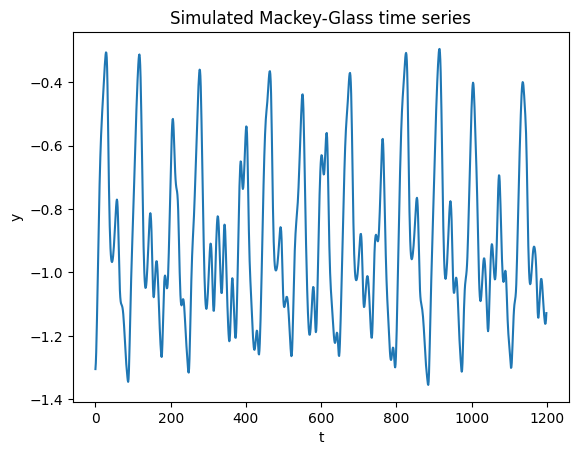

In [ ]:
# Displaying the generated time series
plt.figure()
plt.plot(Y)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Simulated Mackey-Glass time series')
plt.show()


### Building our neural network


In [ ]:
# The parameters of the model that will not be changed across the lab, such as activation functions,
# will not be passed as arguments of the class

class TimeSeriesMLP(keras.Model) :
    def __init__(self, data_dim, output_dim, hidden_nodes, n_epochs, patience, early_stopping = True, lmbda = 0.01):
        super(TimeSeriesMLP, self).__init__()

        self.hidden_nodes = hidden_nodes # list of number of nodes per hidden layer
        self.hidden_n = len(hidden_nodes)
        self.data_dim = data_dim
        self.output_dim = 1
        self.patience = patience
        self.n_epochs = n_epochs
        self.early_stopping = early_stopping
        self.lmbda = lmbda

        self.build_model()

    def build_model(self) :
        self.model = keras.Sequential()

        # Input layer
        self.model.add(Dense(units = self.data_dim, activation=activations.linear, use_bias=True))

        if self.early_stopping :
            # Hidden layers
            for i in range(self.hidden_n) :
                self.model.add(Dense(units = self.hidden_nodes[i], activation = activations.sigmoid, use_bias=True))

            # Output layer
            self.model.add(Dense(units = self.output_dim, activation=activations.linear, use_bias=True))

        else :
            # Hidden layers
            for i in range(self.hidden_n) :
                self.model.add(Dense(units = self.hidden_nodes[i], activation = activations.sigmoid, use_bias=True, kernel_regularizer=regularizers.l2(self.lmbda)))

            # Output layer
            self.model.add(Dense(units = self.output_dim, activation=activations.linear, use_bias=True, kernel_regularizer=regularizers.l2(self.lmbda)))


        # Compile model
        self.model.compile(optimizer='adam', loss='mse')

    def train_model(self, X_train, Y_train, X_val, Y_val) :

        if self.early_stopping :
            # Define early stopping callback
            early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=self.patience, restore_best_weights=True)

            history = self.model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=self.n_epochs, batch_size = 32, verbose = 1, callbacks=[early_stopping])

        else :
            history = self.model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=self.n_epochs, batch_size = 32, verbose = 1)


        return history

    def predict(self, X) :
        return self.model.predict(X)

    def evaluate(self, X_val, Y_val) :
        return self.model.evaluate(X_val, Y_val)



To choose the most robust model with respect to weight initializatoin, we will perform the GridSearch several time, to have an average validation error over each model. This is done by the parameter ``robust_idx``.<br>
At the end of each training, we also compute the test error, but this error is never used to improve the model.


In [ ]:
def grid_search_hidden_layers(X_train, Y_train, X_val, Y_val, X_test, Y_test, hidden_nodes_matrix,
                              patience, n_epochs,
                              early_stopping = True, lmbda = 0.01,
                              robust_idx = 1) :
        # Parameters
        data_dim = X_train.shape[1]
        output_dim = 1

        # Model
        model = [None]*hidden_nodes_matrix.shape[0]
        history = [None]*hidden_nodes_matrix.shape[0]

        mean_validation_error = [0]*hidden_nodes_matrix.shape[0]
        mean_train_error = [0]*hidden_nodes_matrix.shape[0]
        mean_test_error = [0]*hidden_nodes_matrix.shape[0]

        std_validation_error = [0]*hidden_nodes_matrix.shape[0]
        std_train_error = [0]*hidden_nodes_matrix.shape[0]
        std_test_error = [0]*hidden_nodes_matrix.shape[0]

        for i in range(hidden_nodes_matrix.shape[0]) :
                temp_train_error = []
                temp_val_error = []
                temp_test_error = []

                for r in range (robust_idx) :
                        model[i] = TimeSeriesMLP(data_dim=data_dim, output_dim=output_dim, hidden_nodes=hidden_nodes_matrix[i],
                                                 patience=patience, n_epochs=n_epochs,
                                                 early_stopping = True, lmbda = 0.01)

                        # Training model
                        history[i] = model[i].train_model(X_train, Y_train, X_val, Y_val)

                        # Storing error
                        temp_train_error.append(model[i].evaluate(X_train, Y_train))
                        temp_val_error.append(model[i].evaluate(X_val, Y_val))
                        temp_test_error.append(model[i].evaluate(X_test, Y_test))

                # Storing mean and standard deviation of the errors
                mean_train_error[i] = np.mean(np.array(temp_train_error))
                mean_validation_error[i] = np.mean(np.array(temp_val_error))
                mean_test_error[i] = np.mean(np.array(temp_test_error))

                std_train_error[i] = np.std(np.array(temp_train_error))
                std_validation_error[i] = np.std(np.array(temp_val_error))
                std_test_error[i] = np.std(np.array(temp_test_error))

        return model, history, mean_train_error, mean_validation_error, mean_test_error, std_train_error, std_validation_error, std_test_error


In [ ]:
# Parameters
hidden_nodes_matrix = np.array([[i, j] for i in [3, 4, 5] for j in [2, 4, 6]]) # grid search among the nodes configuration
n_epochs = 150
patience = 1

# Parameters
data_dim = X_train.shape[1]
output_dim = 1

robust_idx = 10
model, history, mean_train_error, mean_validation_error, mean_test_error, std_train_error, std_validation_error, std_test_error = grid_search_hidden_layers(X_train=X_train, Y_train=Y_train, X_val=X_val, Y_val=Y_val,
                                                                                                                                                            X_test=X_test, Y_test=Y_test,
                                                                                                                                                            hidden_nodes_matrix=hidden_nodes_matrix,
                                                                                                                                                            patience=patience, n_epochs=n_epochs,
                                                                                                                                                            robust_idx = robust_idx)




Epoch 1/150

25/25 [==============================] - 1s 16ms/step - loss: 0.2030 - val_loss: 0.1698
Epoch 2/150
25/25 [==============================] - 0s 3ms/step - loss: 0.1515 - val_loss: 0.1305
Epoch 3/150
25/25 [==============================] - 0s 4ms/step - loss: 0.1129 - val_loss: 0.1031
Epoch 4/150
25/25 [==============================] - 0s 3ms/step - loss: 0.0867 - val_loss: 0.0875
Epoch 5/150
25/25 [==============================] - 0s 3ms/step - loss: 0.0717 - val_loss: 0.0806
Epoch 6/150
25/25 [==============================] - 0s 4ms/step - loss: 0.0647 - val_loss: 0.0785
Epoch 7/150
25/25 [==============================] - 0s 3ms/step - loss: 0.0620 - val_loss: 0.0782
Epoch 8/150
7/7 [==============================] - 0s 1ms/step - loss: 0.0513
Epoch 1/150
25/25 [==============================] - 1s 8ms/step - loss: 0.7525 - val_loss: 0.5944
Epoch 2/150
25/25 [==============================] - 0s 3ms/step - loss: 0.5412 - val_loss: 0.4276
Epoch 3/150
25/25 [========

In [ ]:
def plot_best_worst_models(history, best_model_idx, worst_model_idx, best_model, worst_model, best_nodes, worst_nodes, X_test) :
    # Predictions
    Y_best_pred = best_model.predict(X_test)
    Y_worst_pred = worst_model.predict(X_test)

    # Plotting the training an validation loss
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    fig.suptitle("Training and validation loss for all architectures and their prediction")

    # Plotting training and validation loss
    ax[0][0].plot(history[best_model_idx].history['loss'])
    ax[0][0].plot(history[best_model_idx].history['val_loss'])

    ax[0][0].set_xlabel('Epochs')
    ax[0][0].set_ylabel('Loss')
    ax[0][0].set_title(f'Best loss : [{best_nodes[0]}, {best_nodes[1]}]')
    ax[0][0].legend(['Training', 'Validation'])

    ax[0][1].plot(history[worst_model_idx].history['loss'])
    ax[0][1].plot(history[worst_model_idx].history['val_loss'])

    ax[0][1].set_xlabel('Epochs')
    ax[0][1].set_ylabel('Loss')
    ax[0][1].set_title(f'Worst loss : [{worst_nodes[0]}, {worst_nodes[1]}]')
    ax[0][1].legend(['Training', 'Validation'])

    # Plotting the predictions
    ax[1][0].plot(Y_test, label='True')
    ax[1][0].plot(Y_best_pred, label='Predicted')
    ax[1][0].set_xlabel('t')
    ax[1][0].set_ylabel('y')
    ax[1][0].set_title(f'Best model : [{best_nodes[0]}, {best_nodes[1]}]')
    ax[1][0].legend()

    ax[1][1].plot(Y_test, label='True')
    ax[1][1].plot(Y_worst_pred, label='Predicted')
    ax[1][1].set_xlabel('t')
    ax[1][1].set_ylabel('y')
    ax[1][1].set_title(f'Worst model : [{worst_nodes[0]}, {worst_nodes[1]}]')
    ax[1][1].legend()

    plt.show()


In [ ]:
# Getting the worst and the best model, using average validation error
best_model_idx = np.argmin(mean_validation_error)
best_model = model[best_model_idx]
best_nodes = hidden_nodes_matrix[best_model_idx]

worst_model_idx = np.argmax(mean_validation_error)
worst_model = model[worst_model_idx]
worst_nodes = hidden_nodes_matrix[worst_model_idx]


7/7 [==============================] - 0s 1ms/step


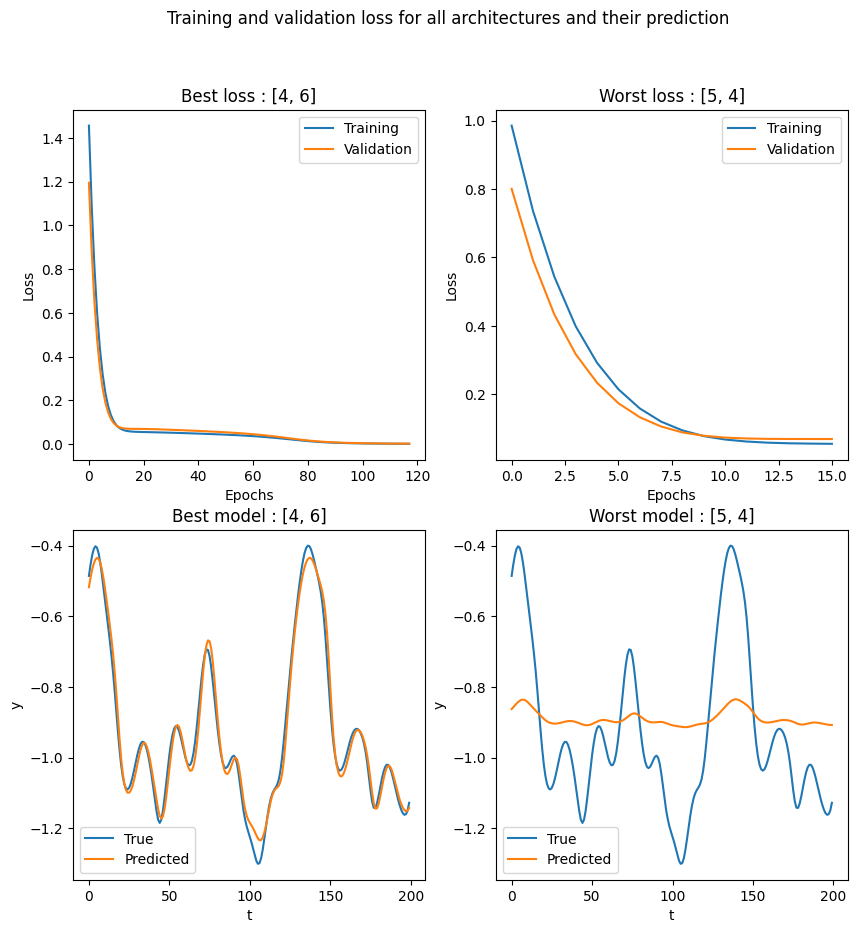

In [ ]:
# Plotting the best and worst models results
plot_best_worst_models(history, best_model_idx, worst_model_idx, best_model, worst_model, best_nodes, worst_nodes, X_test)


25/25 [==============================] - 0s 938us/step - loss: 0.0555


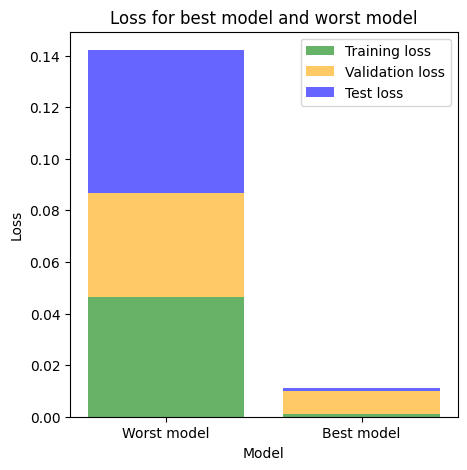

In [ ]:
# Getting test error for the best model and the worst model
best_test_error = best_model.evaluate(X_test, Y_test)
worst_test_error = worst_model.evaluate(X_test, Y_test)

# Getting training error for the best model and the worst model
best_train_error = best_model.evaluate(X_train, Y_train)
worst_train_error = worst_model.evaluate(X_train, Y_train)

# Histogram with x-axis the models and y-axis training, validation and test loss (only the last value)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

idx = ['Worst model', 'Best model']

# Plot bars for test error
ax.bar(idx, [worst_test_error, best_test_error], color='green', alpha=0.6, label='Test loss')

# Plot bars for validation error on top of test error
ax.bar(idx, [mean_validation_error[worst_model_idx], mean_validation_error[best_model_idx]],
       color='orange', alpha=0.6, label='Validation loss', bottom=[worst_test_error, best_test_error])

# Plot bars for training error on top of validation error and test error
ax.bar(idx, [worst_train_error, best_train_error],
       color='blue', alpha=0.6, label='Training loss',
       bottom=[worst_test_error + mean_validation_error[worst_model_idx],
               best_test_error + mean_validation_error[best_model_idx]])

ax.set_xlabel('Model')
ax.set_ylabel('Loss')
ax.set_title(f'Loss for best model and worst model')
ax.legend(['Training loss', 'Validation loss', 'Test loss'])

plt.show()


In [ ]:
### Average test performances of the two models
import pandas as pd

# Create a DataFrame
data = {
    'Model': [f'Best model : [{best_nodes[0]}, {best_nodes[1]}]', f'Worst model : [{worst_nodes[0]}, {worst_nodes[1]}]'],
    'Mean Train Error': [mean_train_error[best_model_idx], mean_train_error[worst_model_idx]],
    'Standard deviation Train Error' : [std_train_error[best_model_idx], std_train_error[worst_model_idx]],
    'Mean Validation Error': [mean_validation_error[best_model_idx], mean_validation_error[worst_model_idx]],
    'Standard deviation Validation Error' : [std_validation_error[best_model_idx], std_validation_error[worst_model_idx]],
    'Mean Test Error': [mean_test_error[best_model_idx], mean_test_error[worst_model_idx]],
    'Standard deviation Test Error' : [std_train_error[best_model_idx], std_train_error[worst_model_idx]]
}

test_perf = pd.DataFrame(data)

test_perf


Model  Mean Train Error  Standard deviation Train Error  \
0   Best model : [4, 6]          0.006917                        0.017953   
1  Worst model : [5, 4]          0.031917                        0.027076   

   Mean Validation Error  Standard deviation Validation Error  \
0               0.008978                             0.022974   
1               0.040252                             0.034164   

   Mean Test Error  Standard deviation Test Error  
0         0.005690                       0.017953  
1         0.026374                       0.027076

### Fitting the best model to noised data


In [ ]:
# Adding white noise to the data
sigmas = [0.05, 0.15]

# Building datasets
X_noised_matrix = []
Y_noised_matrix = []

for sigma in sigmas :
    X_temp, Y_temp = build_dataset(noised = True, noise_std = sigma)
    X_noised_matrix.append(X_temp)
    Y_noised_matrix.append(Y_temp)


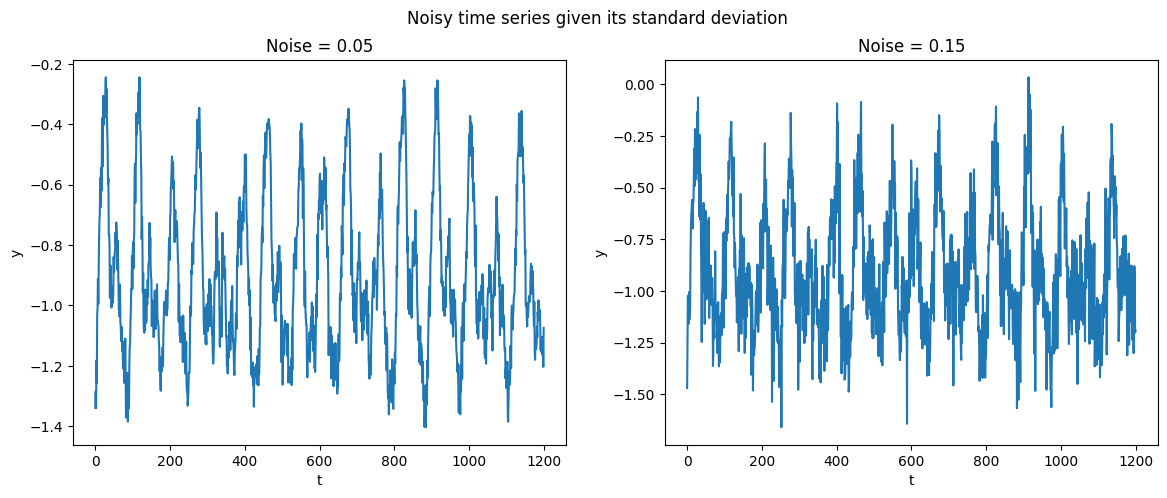

In [ ]:
# Plotting the noise datasets
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle("Noisy time series given its standard deviation")

ax[0].plot(Y_noised_matrix[0])
ax[0].set_xlabel('t')
ax[0].set_ylabel('y')
ax[0].set_title(f'Noise = {sigmas[0]}')

ax[1].plot(Y_noised_matrix[1])
ax[1].set_xlabel('t')
ax[1].set_ylabel('y')
ax[1].set_title(f'Noise = {sigmas[1]}')

plt.show()


In [ ]:
# keeping the number of nodes of the best model for the first layer
hidden_nodes_matrix_noises = np.array([[best_nodes[0], j] for j in [3, 6, 9]])
robust_idx = 10
n_epochs = 150
lmbda = 1

noised_model = []
noised_history = []

noised_mean_train_error = []
noised_mean_validation_error = []
noised_mean_test_error = []

noised_std_train_error = []
noised_std_validation_error = []
noised_std_test_error = []

noised_predictions = []
test_sets = []

# Training all models for different noise values
for i in range(len(sigmas)) :

    # performing grid search on all architecture
    X_train_temp, Y_train_temp, X_val_temp, Y_val_temp, X_test_temp, Y_test_temp = split_data(X_noised_matrix[i], Y_noised_matrix[i])
    temp_model, temp_history, temp_mean_train_error, temp_mean_validation_error, temp_mean_test_error, temp_std_train_error, temp_std_validation_error, temp_std_test_error = grid_search_hidden_layers(X_train=X_train_temp, Y_train=Y_train_temp,
                                                                                                                                                                                                        X_val=X_val_temp, Y_val=Y_val_temp,
                                                                                                                                                                                                        X_test=X_test_temp, Y_test=Y_test_temp,
                                                                                                                                                                                                        hidden_nodes_matrix = hidden_nodes_matrix_noises,
                                                                                                                                                                                                        patience=patience, n_epochs=n_epochs,
                                                                                                                                                                                                        early_stopping=False, lmbda=lmbda,
                                                                                                                                                                                                        robust_idx = robust_idx)

    # storing each model data
    noised_model.append(temp_model)
    noised_history.append(temp_history)

    noised_mean_train_error.append(temp_mean_train_error)
    noised_mean_validation_error.append(temp_mean_validation_error)
    noised_mean_test_error.append(temp_mean_test_error)

    noised_std_train_error.append(temp_std_train_error)
    noised_std_validation_error.append(temp_std_validation_error)
    noised_std_test_error.append(temp_std_test_error)


    # storing predictions of each architecture
    test_sets.append(Y_test_temp)
    temp_predictions = [model.predict(X_test_temp) for model in temp_model]
    noised_predictions.append(temp_predictions)


Epoch 1/150
25/25 [==============================] - 1s 7ms/step - loss: 1.5853 - val_loss: 1.3188
Epoch 2/150
25/25 [==============================] - 0s 2ms/step - loss: 1.2108 - val_loss: 0.9934
Epoch 3/150
25/25 [==============================] - 0s 2ms/step - loss: 0.9083 - val_loss: 0.7400
Epoch 4/150
25/25 [==============================] - 0s 2ms/step - loss: 0.6776 - val_loss: 0.5496
Epoch 5/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5060 - val_loss: 0.4101
Epoch 6/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3791 - val_loss: 0.3098
Epoch 7/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2870 - val_loss: 0.2357
Epoch 8/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2189 - val_loss: 0.1825
Epoch 9/150
25/25 [==============================] - 0s 2ms/step - loss: 0.1693 - val_loss: 0.1444
Epoch 10/150
25/25 [==============================] - 0s 2ms/step - loss: 0.1330 - val_loss: 0.1176
Epoch 11/

In [ ]:
def plot_noised_loss(sigmas, param, history) :
    fig, ax = plt.subplots(len(sigmas), len(param), figsize=(15, 10))

    fig.suptitle("Training and validation loss of all architectures and data types")

    for i in range(len(sigmas)):
        for j in range(len(param)):
            ax[i][j].plot(history[i][j].history['loss'])
            ax[i][j].plot(history[i][j].history['val_loss'])
            ax[i][j].set_xlabel('Epochs')
            ax[i][j].set_ylabel('Loss')
            ax[i][j].set_title(f'Noise = {sigmas[i]}, parameter = {param[j]}')
            ax[i][j].legend(['Training', 'Validation'])
    plt.show()

def plot_noised_predictions(sigmas, param, predictions, test_sets) :
    fig, ax = plt.subplots(len(sigmas), len(param), figsize=(15, 10))

    fig.suptitle("Prediction using all architectures and data types")

    for i in range(len(sigmas)) :
        for j in range(len(param)) :
            ax[i][j].plot(test_sets[i], label='True')
            ax[i][j].plot(predictions[i][j], label='Predicted')
            ax[i][j].set_xlabel('t')
            ax[i][j].set_ylabel('y')
            ax[i][j].set_title(f'Noise = {sigmas[i]}, parameters = {param[j]}')
            ax[i][j].legend()

    plt.show()

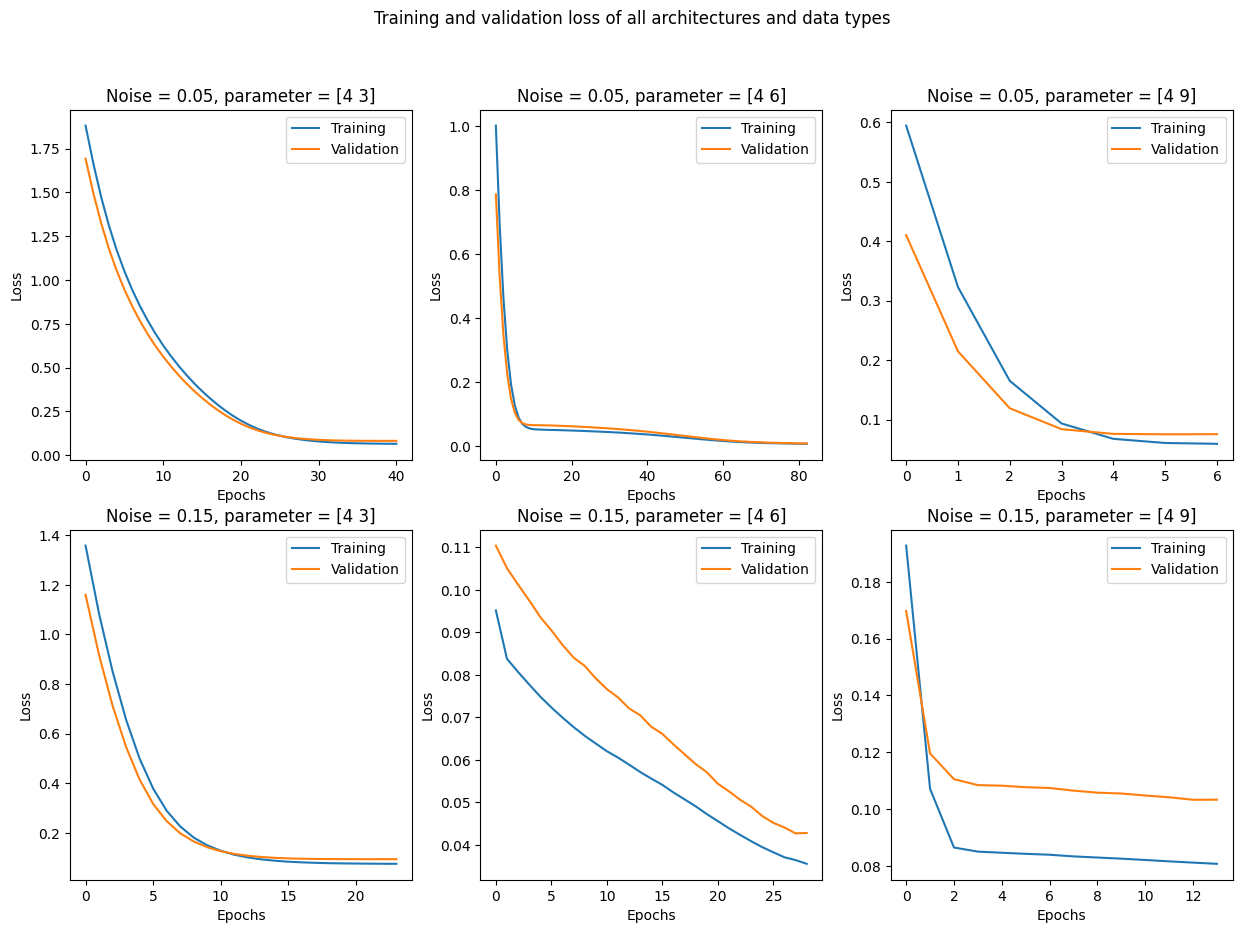

In [ ]:
# Plot the train loss and validation loss for each model
plot_noised_loss(sigmas, hidden_nodes_matrix_noises, noised_history)


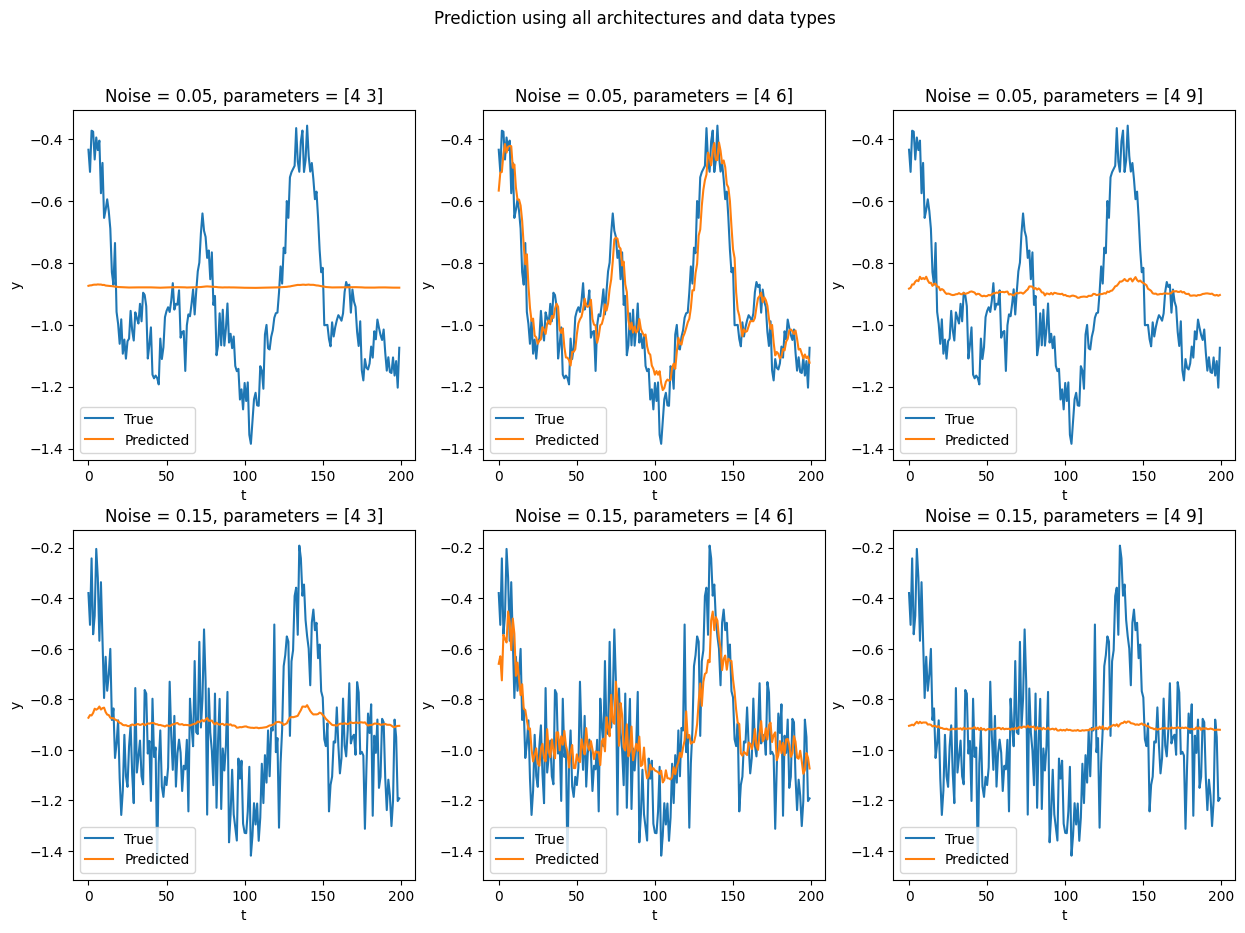

In [ ]:
# Plot the prediction for each model
plot_noised_predictions(sigmas, hidden_nodes_matrix_noises, noised_predictions, test_sets)


In [ ]:
# Selecting a good architecture in average for each noise value
best_model_noised_idx = np.argmin(noised_mean_validation_error)
best_model_noised_idx = np.unravel_index(best_model_noised_idx, np.array(noised_mean_validation_error).shape)
bests_nodes_noised = hidden_nodes_matrix_noises[best_model_noised_idx[1]]
print(f'Best architecture for noise = {sigmas[best_model_noised_idx[0]]} : {bests_nodes_noised}')

Best architecture for noise = 0.05 : [4 6]


### Impact of the regularizer
- choisir un modèle
- mettre plusieurs valeurs de regularizer et comparer


In [ ]:
def grid_search_lmbds(X_train, Y_train, X_val, Y_val, X_test, Y_test, hidden_nodes, lmbds,
                              patience, n_epochs,
                              early_stopping = True,
                              robust_idx = 1) :
        # Parameters
        data_dim = X_train.shape[1]
        output_dim = 1

        # Model
        model = [None]*lmbds.shape[0]
        history = [None]*lmbds.shape[0]

        mean_validation_error = [0]*lmbds.shape[0]
        mean_train_error = [0]*lmbds.shape[0]
        mean_test_error = [0]*lmbds.shape[0]

        std_validation_error = [0]*lmbds.shape[0]
        std_train_error = [0]*lmbds.shape[0]
        std_test_error = [0]*lmbds.shape[0]

        for i in range(lmbds.shape[0]) :
                temp_train_error = []
                temp_val_error = []
                temp_test_error = []

                for r in range (robust_idx) :
                        model[i] = TimeSeriesMLP(data_dim=data_dim, output_dim=output_dim, hidden_nodes=hidden_nodes,
                                                 patience=patience, n_epochs=n_epochs,
                                                 early_stopping = True, lmbda = lmbds[i])

                        # Training model
                        history[i] = model[i].train_model(X_train, Y_train, X_val, Y_val)

                        # Storing error
                        temp_train_error.append(model[i].evaluate(X_train, Y_train))
                        temp_val_error.append(model[i].evaluate(X_val, Y_val))
                        temp_test_error.append(model[i].evaluate(X_test, Y_test))

                # Storing mean and standard deviation of the errors
                mean_train_error[i] = np.mean(np.array(temp_train_error))
                mean_validation_error[i] = np.mean(np.array(temp_val_error))
                mean_test_error[i] = np.mean(np.array(temp_test_error))

                std_train_error[i] = np.std(np.array(temp_train_error))
                std_validation_error[i] = np.std(np.array(temp_val_error))
                std_test_error[i] = np.std(np.array(temp_test_error))

        return model, history, mean_train_error, mean_validation_error, mean_test_error, std_train_error, std_validation_error, std_test_error


This part of the code could be factorized as it it very similar to the one above when choosing the model for noised data.


In [ ]:
# grid search among the lambdas
lmbds = np.array([0.001, 0.005, 0.1, 1])

# keeping the number of nodes of the best model for the first layer
robust_idx = 10
n_epochs = 150

lmbd_model = []
lmbd_history = []

lmbd_mean_train_error = []
lmbd_mean_validation_error = []
lmbd_mean_test_error = []

lmbd_std_train_error = []
lmbd_std_validation_error = []
lmbd_std_test_error = []

lmbd_predictions = []
test_sets = []

# Training all models for different noise values
for i in range(len(sigmas)) :

    # performing grid search on all architecture
    X_train_temp, Y_train_temp, X_val_temp, Y_val_temp, X_test_temp, Y_test_temp = split_data(X_noised_matrix[i], Y_noised_matrix[i])
    temp_model, temp_history, temp_mean_train_error, temp_mean_validation_error, temp_mean_test_error, temp_std_train_error, temp_std_validation_error, temp_std_test_error = grid_search_lmbds(X_train=X_train_temp, Y_train=Y_train_temp,
                                                                                                                                                                                                        X_val=X_val_temp, Y_val=Y_val_temp,
                                                                                                                                                                                                        X_test=X_test_temp, Y_test=Y_test_temp,
                                                                                                                                                                                                        hidden_nodes = bests_nodes_noised,
                                                                                                                                                                                                        lmbds=lmbds,
                                                                                                                                                                                                        patience=patience, n_epochs=n_epochs,
                                                                                                                                                                                                        early_stopping=False,
                                                                                                                                                                                                        robust_idx = robust_idx)

    # storing each model data
    lmbd_model.append(temp_model)
    lmbd_history.append(temp_history)

    lmbd_mean_train_error.append(temp_mean_train_error)
    lmbd_mean_validation_error.append(temp_mean_validation_error)
    lmbd_mean_test_error.append(temp_mean_test_error)

    lmbd_std_train_error.append(temp_std_train_error)
    lmbd_std_validation_error.append(temp_std_validation_error)
    lmbd_std_test_error.append(temp_std_test_error)


    # storing predictions of each architecture
    test_sets.append(Y_test_temp)
    temp_predictions = [model.predict(X_test_temp) for model in temp_model]
    lmbd_predictions.append(temp_predictions)



Epoch 1/150


25/25 [==============================] - 1s 10ms/step - loss: 0.0662 - val_loss: 0.0830
Epoch 2/150
25/25 [==============================] - 0s 3ms/step - loss: 0.0634 - val_loss: 0.0802
Epoch 3/150
25/25 [==============================] - 0s 3ms/step - loss: 0.0611 - val_loss: 0.0769
Epoch 4/150
25/25 [==============================] - 0s 3ms/step - loss: 0.0585 - val_loss: 0.0738
Epoch 5/150
25/25 [==============================] - 0s 3ms/step - loss: 0.0561 - val_loss: 0.0701
Epoch 6/150
25/25 [==============================] - 0s 3ms/step - loss: 0.0535 - val_loss: 0.0666
Epoch 7/150
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0623
Epoch 8/150
25/25 [==============================] - 0s 3ms/step - loss: 0.0477 - val_loss: 0.0585
Epoch 9/150
25/25 [==============================] - 0s 3ms/step - loss: 0.0444 - val_loss: 0.0546
Epoch 10/150
25/25 [==============================] - 0s 4ms/step - loss: 0.0412 - val_loss: 0.0500
Epoch 11/150
25/25 [

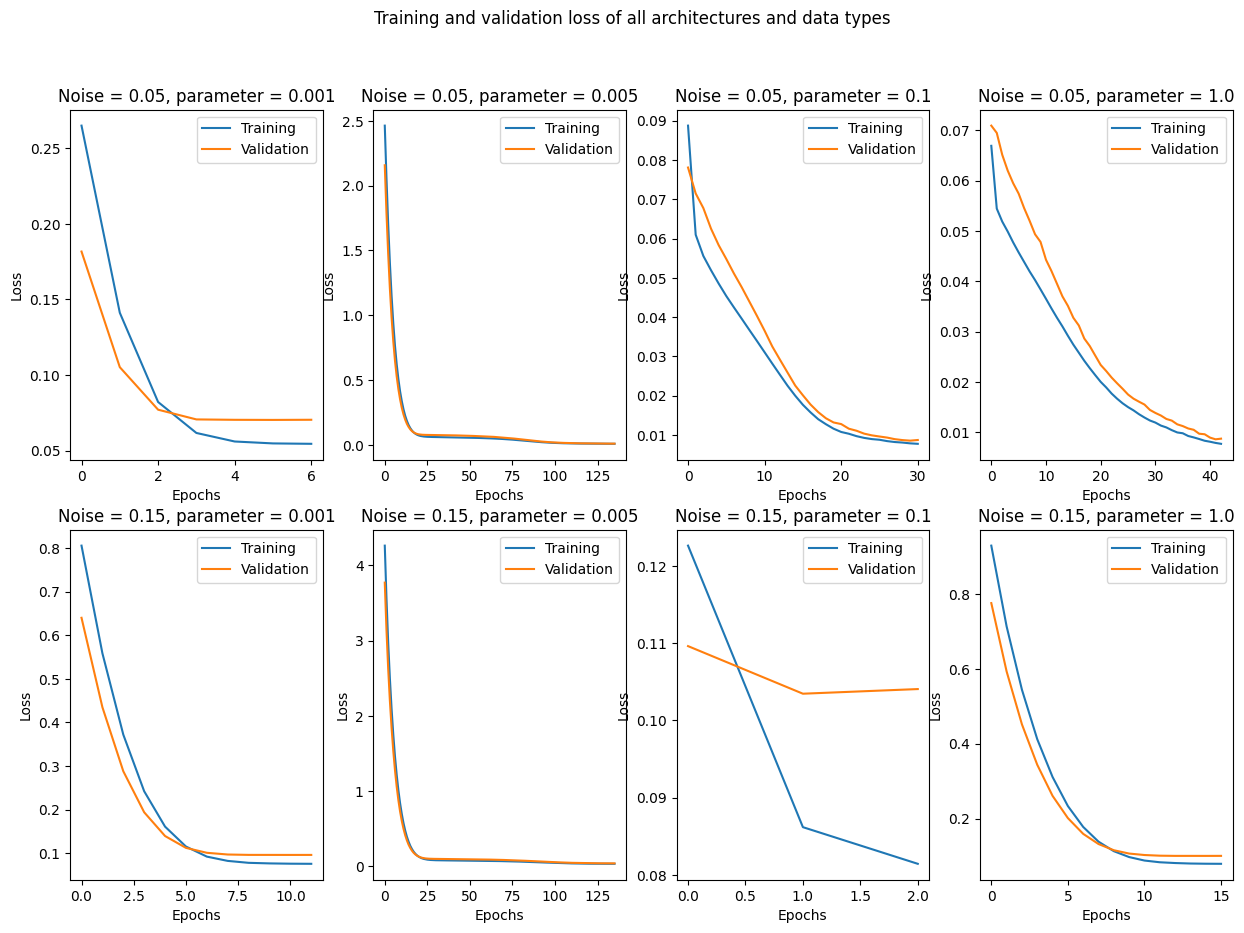

In [ ]:
# Plotting val loss and train loss of all models
plot_noised_loss(sigmas, lmbds, lmbd_history)


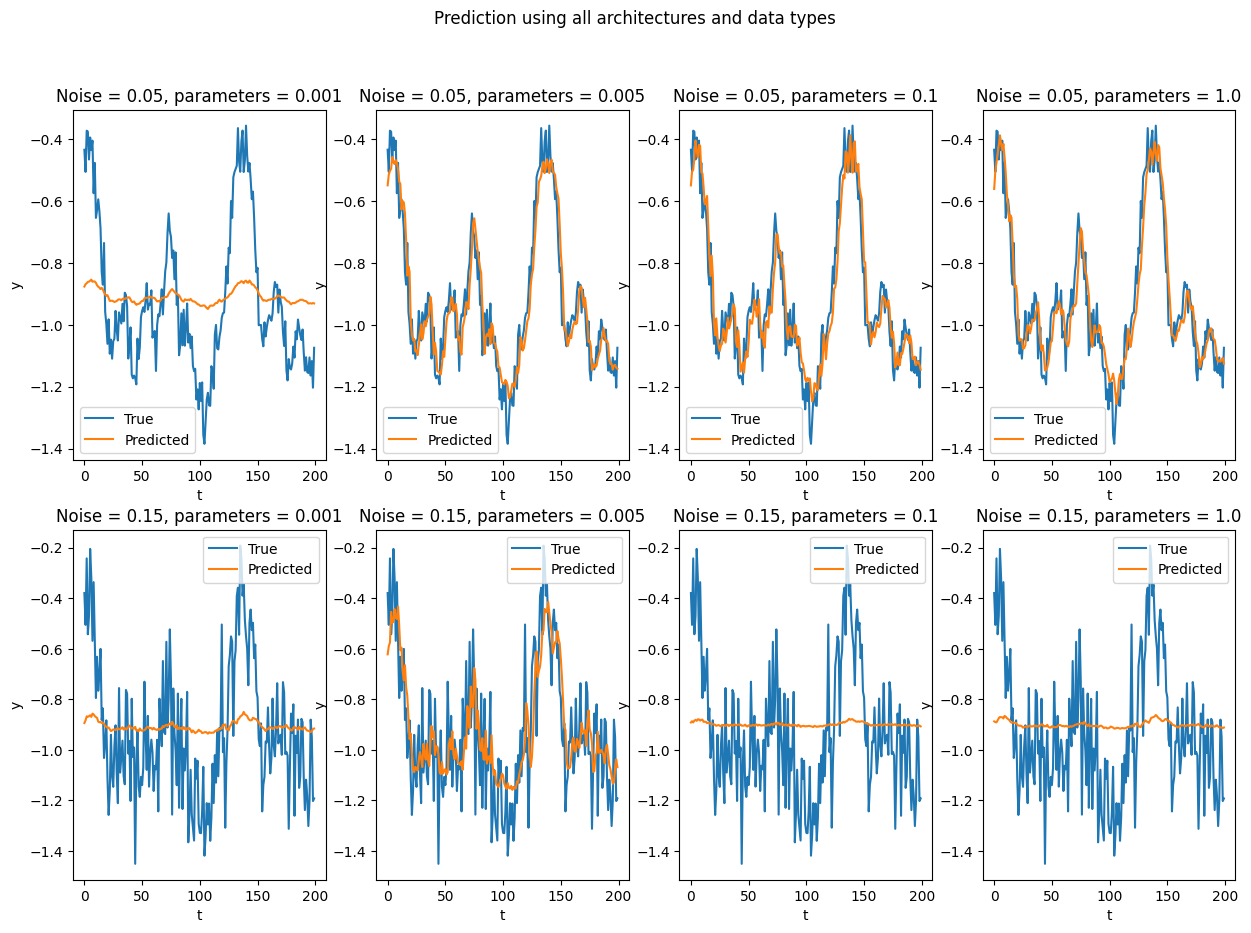

In [ ]:
# Plotting predictions of all models
plot_noised_predictions(sigmas, lmbds, lmbd_predictions, test_sets)

In [ ]:
import pandas as pd

# Create a list to store the dataframes
dfs = []

# Iterate over the sigmas list
for i in range(len(sigmas)):
    # Create a dictionary to store the data
    data = {
        'Lambda': lmbds,
        'Mean Train Error': lmbd_mean_train_error[i],
        'Mean Validation Error': lmbd_mean_validation_error[i],
        'Mean Test Error': lmbd_mean_test_error[i],
        'Std Train Error': lmbd_std_train_error[i],
        'Std Validation Error': lmbd_std_validation_error[i],
        'Std Test Error': lmbd_std_test_error[i]
    }

    # Create the dataframe
    df = pd.DataFrame(data)

    # Append the dataframe to the list
    dfs.append(df)


In [ ]:
dfs[0]

Lambda  Mean Train Error  Mean Validation Error  Mean Test Error  \
0   0.001          0.017758               0.021600         0.014752   
1   0.005          0.017846               0.021704         0.014919   
2   0.100          0.012817               0.015368         0.010660   
3   1.000          0.017984               0.021583         0.015141   

   Std Train Error  Std Validation Error  Std Test Error  
0         0.021086              0.027311        0.017928  
1         0.021101              0.027087        0.017883  
2         0.016166              0.020774        0.013755  
3         0.021714              0.027408        0.018652

In [ ]:
dfs[1]

Lambda  Mean Train Error  Mean Validation Error  Mean Test Error  \
0   0.001          0.044061               0.053673         0.041166   
1   0.005          0.040696               0.048941         0.038337   
2   0.100          0.041775               0.050371         0.038961   
3   1.000          0.059478               0.073783         0.052953   

   Std Train Error  Std Validation Error  Std Test Error  
0         0.019528              0.025512        0.014862  
1         0.017832              0.023042        0.013790  
2         0.019377              0.025618        0.015195  
3         0.022667              0.029717        0.017681

### Weight distribution

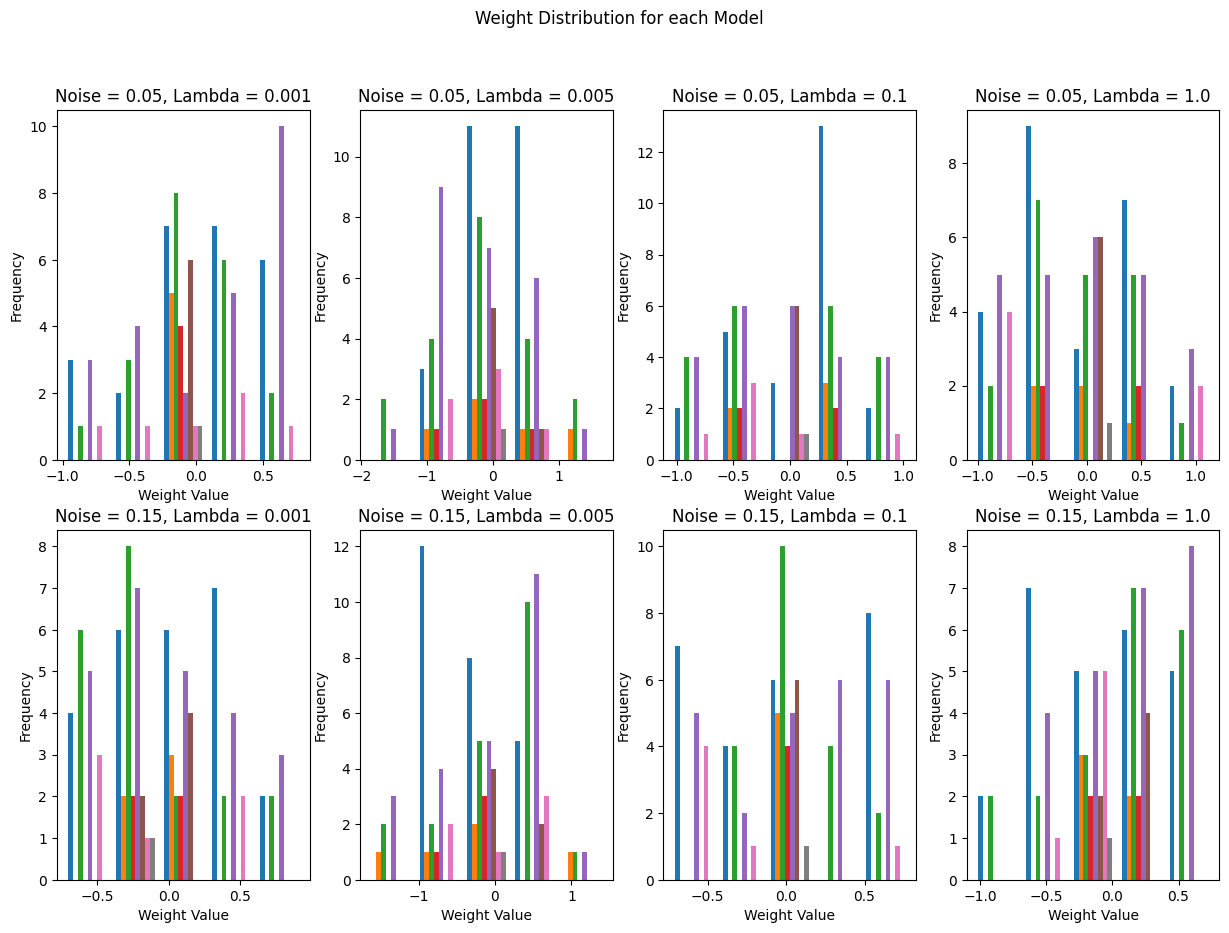

In [ ]:
def plot_weight_distribution(models, lmbds, sigmas):
    fig, ax = plt.subplots(len(sigmas), len(lmbds), figsize=(15, 10))

    fig.suptitle("Weight Distribution for each Model")

    for i in range(len(sigmas)):
        for j in range(len(lmbds)):
            weights = models[i][j].get_weights()
            flattened_weights = [w.flatten() for w in weights]

            ax[i][j].hist(flattened_weights, bins=5)
            ax[i][j].set_xlabel('Weight Value')
            ax[i][j].set_ylabel('Frequency')
            ax[i][j].set_title(f'Noise = {sigmas[i]}, Lambda = {lmbds[j]}')

    plt.show()

# Call the function to plot the weight distribution
plot_weight_distribution(lmbd_model, lmbds, sigmas)
